In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ls.config.loader import load_config
import pandas as pd
import os
import numpy as np

#### Load configuration file

In [3]:
cfg = load_config("../configs/config.yaml")

In [4]:
df = pd.read_csv(os.path.join(cfg.dataset.data_folder, "icbhi_metadata.csv"))

#### Create columns for 4-class and 2-class problems and cycle duraitons

In [5]:
df['label_4c'] = df.apply(lambda r: 
    'Crackle' if r.Crackles==1 and r.Wheezes==0 else
    'Wheeze'  if r.Crackles==0 and r.Wheezes==1 else
    'Both'    if r.Crackles==1 and r.Wheezes==1 else
    'Normal', axis=1)

In [6]:
df["label_2c"] = np.where((df["Crackles"] + df["Wheezes"]) > 0, "Abnormal", "Normal")
df['CycleDur'] = df['CycleEnd'] - df['CycleStart']

df.head()

,PID,Filename,CycleIndex,CycleStart,CycleEnd,Crackles,Wheezes,Split,Device,Fold,Age,Sex,BMI,CW,CH,Disease,AuscLoc,label_4c,label_2c,CycleDur
0,101,101_1b1_Al_sc_Meditron,0,0.036,0.579,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,0.543
1,101,101_1b1_Al_sc_Meditron,1,0.579,2.450,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.871
2,101,101_1b1_Al_sc_Meditron,2,2.450,3.893,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.443
3,101,101_1b1_Al_sc_Meditron,3,3.893,5.793,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.900
4,101,101_1b1_Al_sc_Meditron,4,5.793,7.521,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.728


In [16]:
df[df["BMI"].isna()].loc[:, "CW":"CH"].isna().sum()

CW    145
CH    168
dtype: int64

In [18]:
df.Sex.isna().sum()

np.int64(61)

In [17]:
df.Age.isna().sum()

np.int64(61)

# Metadata Dataset Exploitation, Descriptive Statistics & Statistical Analysis

### Patients and recordings Information

In [7]:
# Filter data to ensure only PIDs with multiple cycles are used (which is all of them here)
print(f"Total unique patients (PIDs): {df['PID'].nunique()}")
pids_counts = df['PID'].value_counts()
valid_pids = pids_counts[pids_counts > 1].index
if len(valid_pids) < df['PID'].nunique():
    df = df[df['PID'].isin(valid_pids)]
    print(f"Filtered to PIDs with multiple cycles. New total unique PIDs: {df['PID'].nunique()}")
print(f"Total unique recordings: {df['Filename'].nunique()}")
print(f"Total cycles analyzed: {len(df)}")

print(f"Each patient contributes an average of {df.groupby('Filename').size().mean():.2f} lung sound recordings, " \
      f"and an average of {df.groupby('PID').size().mean():.2f} cycles."
)

Total unique patients (PIDs): 126
Total unique recordings: 920
Total cycles analyzed: 6898
Each patient contributes an average of 7.50 lung sound recordings, and an average of 54.75 cycles.


### Check for patient leakage/overlap between train and test sets

In [8]:
# Basic integrity checks
assert df["PID"].nunique() == df.groupby("PID")["Split"].nunique().max(), "A PID appears in both splits!"

AssertionError: A PID appears in both splits!

In [9]:
dup_pids = (
    df.groupby("PID")["Split"]
      .nunique()
      .reset_index()
      .query("Split > 1")
)

if not dup_pids.empty:
    print("Patients appearing in both training and test splits:")
    display(df[df["PID"].isin(dup_pids["PID"])][["PID","Filename", "Split"]].drop_duplicates())

Patients appearing in both training and test splits:


,PID,Filename,Split
2896,156,156_2b3_Al_mc_AKGC417L,test
2902,156,156_2b3_Ar_mc_AKGC417L,train
2908,156,156_2b3_Ll_mc_AKGC417L,train
2914,156,156_2b3_Lr_mc_AKGC417L,test
2920,156,156_2b3_Pl_mc_AKGC417L,test
2926,156,156_2b3_Pr_mc_AKGC417L,train
2932,156,156_5b3_Al_mc_AKGC417L,train
2941,156,156_5b3_Ar_mc_AKGC417L,test
2950,156,156_5b3_Ll_mc_AKGC417L,test
2959,156,156_5b3_Lr_mc_AKGC417L,train


In [10]:
assert (df["CycleDur"] > 0).all(), "Non-positive cycle duration found"

In [11]:
def print_section(title, df):
    print("\n" + "="*80)
    print(f"{title.upper()}")
    print("="*80)
    print(df.to_string())
    print()

### Class imbalances Calculation or the official fixed train/test split (2-class & 4-class problem)

### Global Dataset (Train + Test)

In [12]:
print_section("4-Class Global Counts", df["label_4c"].value_counts().to_frame("count"))
print_section("4-Class Global Proportions", df["label_4c"].value_counts(normalize=True).round(3).to_frame("proportion"))

print_section("2-Class Global Counts", df["label_2c"].value_counts().to_frame("count"))
print_section("2-Class Global Proportions", df["label_2c"].value_counts(normalize=True).round(3).to_frame("proportion"))


4-CLASS GLOBAL COUNTS
          count
label_4c       
Normal     3642
Crackle    1864
Wheeze      886
Both        506


4-CLASS GLOBAL PROPORTIONS
          proportion
label_4c            
Normal         0.528
Crackle        0.270
Wheeze         0.128
Both           0.073


2-CLASS GLOBAL COUNTS
          count
label_2c       
Normal     3642
Abnormal   3256


2-CLASS GLOBAL PROPORTIONS
          proportion
label_2c            
Normal         0.528
Abnormal       0.472



### Class imbalances for each split (4-class problem)

In [13]:
# By split
by_split_4c = df.pivot_table(index="Split", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
by_split_prop_4c = by_split_4c.div(by_split_4c.sum(axis=1), axis=0).round(3)
print_section("4-Class Counts by Split", by_split_4c)
print_section("4-Class Proportions by Split", by_split_prop_4c)
# print("\n4c counts by Split:\n", by_split)
# print("\n4c proportions by Split:\n", by_split_prop)


4-CLASS COUNTS BY SPLIT
label_4c  Both  Crackle  Normal  Wheeze
Split                                  
test       143      649    1579     385
train      363     1215    2063     501


4-CLASS PROPORTIONS BY SPLIT
label_4c   Both  Crackle  Normal  Wheeze
Split                                   
test      0.052    0.235   0.573   0.140
train     0.088    0.293   0.498   0.121



### Class imbalances for each split (2-class problem)

In [14]:
# By split
by_split = df.pivot_table(index="Split", columns="label_2c", values="Filename", aggfunc="count").fillna(0).astype(int)
by_split_prop = by_split.div(by_split.sum(axis=1), axis=0).round(3)
print_section("2-Class Counts by Split", by_split)
print_section("2-Class Proportions by Split", by_split_prop)


2-CLASS COUNTS BY SPLIT
label_2c  Abnormal  Normal
Split                     
test          1177    1579
train         2079    2063


2-CLASS PROPORTIONS BY SPLIT
label_2c  Abnormal  Normal
Split                     
test         0.427   0.573
train        0.502   0.498



### Findings:

* Global 4-class: Normal 52.8%, Crackle 27.0%, Wheeze 12.8%, Both 7.3%.
* 2-class: Normal 52.8% vs Abnormal 47.2% → close to balanced.

Train–test label mix isn’t identical

* Test has more Normal (57.3%) and fewer Crackle (23.5%) & Both (5.2%) than Train (Normal 49.8%, Crackle 29.3%, Both 8.8%).   
 -> Expect lower sensitivity on test (especially for Crackle/Both) if you tune on train-like prevalence.

### Descriptive statistics for the breathing cycle duraiton for the 4-class problem

/var/folders/y3/yj6tdm7s4yg87gtqj7lttyy00000gn/T/ipykernel_45398/604060616.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label_4c', y='CycleDur', data=df,


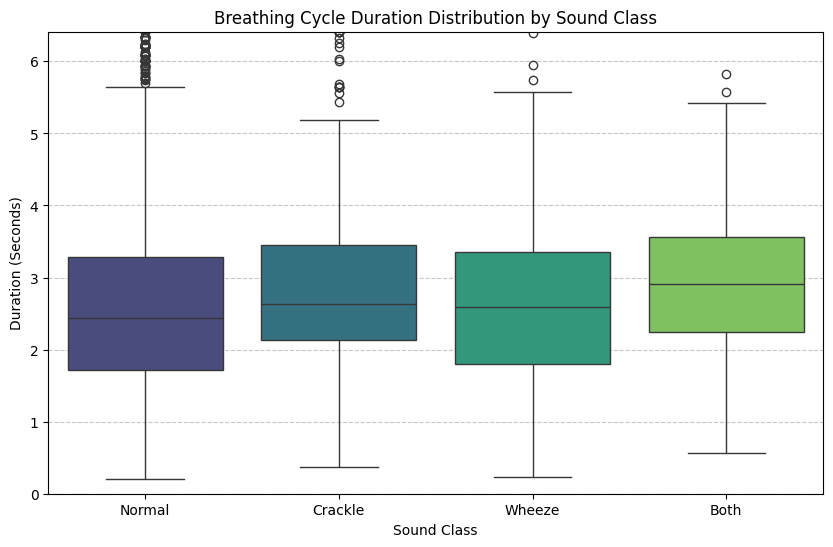

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='label_4c', y='CycleDur', data=df,
            order=['Normal', 'Crackle', 'Wheeze', 'Both'],
            palette='viridis')
plt.title('Breathing Cycle Duration Distribution by Sound Class')
plt.xlabel('Sound Class')
plt.ylabel('Duration (Seconds)')
plt.ylim(0, df['CycleDur'].quantile(0.99))
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('duration_boxplot.png')
# plt.show() # Display the plot

In [16]:
dur_stats = df.groupby("label_4c")["CycleDur"].describe().round(3)
# print("\nCycle duration stats (sec) by 4c:\n", dur_stats)

# per-split duration sanity
dur_split = df.groupby(["Split","label_4c"])["CycleDur"].describe().round(3)
# print("\nCycle duration stats by Split × 4c:\n", dur_split)

print_section("Cycle Duration Stats (sec) by 4-Class Label", dur_stats)
print_section("Cycle Duration Stats (sec) by Split × Label", dur_split)


CYCLE DURATION STATS (SEC) BY 4-CLASS LABEL
           count   mean    std    min    25%    50%    75%     max
label_4c                                                          
Both       506.0  3.060  1.092  0.571  2.238  2.904  3.558   8.592
Crackle   1864.0  2.785  0.952  0.367  2.137  2.629  3.449   8.736
Normal    3642.0  2.607  1.275  0.200  1.716  2.443  3.288  16.163
Wheeze     886.0  2.703  1.143  0.228  1.803  2.584  3.357   9.217


CYCLE DURATION STATS (SEC) BY SPLIT × LABEL
                 count   mean    std    min    25%    50%    75%     max
Split label_4c                                                          
test  Both       143.0  3.358  1.316  1.057  2.277  3.233  4.007   8.592
      Crackle    649.0  3.093  0.923  0.443  2.605  3.212  3.773   6.411
      Normal    1579.0  2.391  1.037  0.286  1.564  2.310  3.141   7.632
      Wheeze     385.0  2.668  1.259  0.228  1.583  2.512  3.456   9.217
train Both       363.0  2.942  0.967  0.571  2.238  2.734  3.417   7.

## Do breathing cycle durations differ between sound classes?

H₀:

Cycle duration distributions are identical across Normal, Crackle, Wheeze, and Both.

H₁:

At least one label’s duration distribution differs.

**Goal:**  
We want to test whether **breathing cycle duration** differs significantly between sound classes (`normal`, `crackle`, `wheeze`, `both`)

### Rationale
Cycles are *nested within patients*, so samples are **not independent**. We therefore use two complementary, statistically approaches:

1. **Paired non-parametric tests on per-patient means**  
   - Compute per-patient mean `CycleDur` for each class -> a *within-subject* design  
   - For each pair of classes, run **Wilcoxon signed-rank** test (paired) on patients who have both classes  
   - Multiple-testing correction (Holm/Bonferroni)

2. **Linear Mixed-Effects Model (LMM)**  
   - Model: `CycleDur ~ C(label_4c) + (1 | PID)`  
   - Refit the LMM cycling the **reference class** to recover **all pairwise** comparisons directly from model coefficients  
   - Multiple-testing correction across all pairs

In [17]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import wilcoxon
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

In [18]:
group_names = df["label_4c"].unique().tolist()

# Pivot to patient × class table of means
df_pmeans = (
    df.groupby(["PID", "label_4c"])["CycleDur"]
      .mean()
      .unstack()
)
display(df_pmeans.head())
    
def wilcoxon_all_pairs(df_pmeans, labels, correction="holm"): # 'holm' is slightly less conservative than Bonferroni
    """
    Run paired Wilcoxon on per-patient means for all class pairs.
    Only patients with both classes present are used per comparison.
    Returns a summary DataFrame with multiple-testing correction.
    """
    rows = []
    for a, b in itertools.combinations(labels, 2):

        pair_df = df_pmeans[[a, b]].dropna()
        n = len(pair_df)
        if n < 5:
            rows.append({"pair": f"{a} vs {b}", "n": n, "W": np.nan, "p_raw": np.nan,
                         "note": "insufficient paired patients"})
            continue
        stat, p = wilcoxon(pair_df[a], pair_df[b], zero_method="wilcox", alternative="two-sided")
        rows.append({"pair": f"{a} vs {b}", "n": n, "W": stat, "p_raw": p, "note": ""})
    out = pd.DataFrame(rows)
    if out.empty:
        return out
    # Multiple testing correction
    mask = out["p_raw"].notna()
    if mask.any():
        reject, p_corr, _, _ = multipletests(out.loc[mask, "p_raw"], method=correction)
        out.loc[mask, "p_corr"] = p_corr
        out.loc[mask, "reject@0.05"] = reject
    else:
        out["p_corr"] = np.nan
        out["reject@0.05"] = False
    return out.sort_values("p_corr")

wilcox_df = wilcoxon_all_pairs(df_pmeans, group_names, correction="bonferroni")
print("\n=== Paired Wilcoxon on per-patient means ===")
display(wilcox_df)

label_4c,Both,Crackle,Normal,Wheeze
PID,,,,
101,NaN,NaN,1.731652,NaN
102,NaN,NaN,1.515385,NaN
103,NaN,NaN,3.186000,3.31075
104,NaN,1.5673,2.196492,1.90480
105,NaN,NaN,2.483875,NaN



=== Paired Wilcoxon on per-patient means ===


,pair,n,W,p_raw,note,p_corr,reject@0.05
2,Normal vs Both,34,102.0,0.000501,,0.003009,True
1,Normal vs Crackle,72,814.0,0.005018,,0.030111,True
4,Wheeze vs Both,34,148.0,0.009574,,0.057445,False
0,Normal vs Wheeze,62,657.0,0.025088,,0.150531,False
5,Crackle vs Both,30,164.0,0.164184,,0.985104,False
3,Wheeze vs Crackle,45,475.0,0.815448,,1.000000,False


### Linear Mixed-Effects Model & Pairwise Comparisons

Now that we know our samples are *not independent* (multiple cycles per patient),  
we use a **Linear Mixed-Effects Model (LMM)** to formally test:


$\text{CycleDur} = \beta_0 + \beta_{\text{class}} + u_{\text{PID}} + \epsilon$

where:
- **fixed effect:** sound class (`label_4c`)  
- **random effect:** patient intercept (`PID`)

After fitting, we compute **pairwise contrasts** between classes to see *which pairs* differ significantly.

In [19]:
# Mixed-Effects Model (confirmatory, all pairwise)
def fit_lmm_with_reference(reference_label: str):
    """
    Fits a mixed-effects model with a given reference label.
    Returns the fitted result, total SD, and variance components.
    """
    formula = f"CycleDur ~ C(label_4c, Treatment(reference='{reference_label}'))"
    model = smf.mixedlm(formula, data=df, groups=df["PID"])
    res = model.fit(method="lbfgs", reml=True, disp=0)
    # variance components
    var_re = float(res.cov_re.iloc[0, 0])       # random intercept variance
    var_resid = float(res.scale)                # residual variance
    sd_total = np.sqrt(var_re + var_resid)      # total SD for standardization
    return res, sd_total, var_re, var_resid

# Fit LMM per reference and extract pairwise comparisons
lmm_rows = []
for ref in group_names:
    res, sd_total, var_re, var_resid = fit_lmm_with_reference(ref)
    params, pvals, tvals = res.params, res.pvalues, res.tvalues
    df_resid = res.df_resid
    for other in group_names:
        if other == ref:
            continue
        term = f"C(label_4c, Treatment(reference='{ref}'))[T.{other}]"
        if term in params.index:
            est = float(params[term])
            p = float(pvals[term])
            t = float(tvals[term])
            # Effect sizes
            d_mixed = est / sd_total
            partial_r2 = (t**2) / (t**2 + df_resid)
            lmm_rows.append({
                "pair": f"{ref} vs {other}",                # mean(other) - mean(ref)
                "est_diff_s": est,
                "p_raw": p,
                "t_value": t,
                "Cohen_d_mixed": d_mixed,
                "partial_R2": partial_r2,
                "ref": ref,
                "var_re": var_re,
                "var_resid": var_resid,
                "sd_total": sd_total
            })

# Deduplicate unordered pairs (keep smallest p-value)
def canon_pair(pair_str):
    a, _, b = pair_str.partition(" vs ")
    return " vs ".join(sorted([a.strip(), b.strip()]))

lmm_df = pd.DataFrame(lmm_rows)
if not lmm_df.empty:
    lmm_df["canon"] = lmm_df["pair"].apply(canon_pair)
    lmm_df = lmm_df.sort_values("p_raw").drop_duplicates("canon", keep="first")
    lmm_df = lmm_df.drop(columns=["canon"]).reset_index(drop=True)
    # Multiple testing correction (Bonferroni)
    reject, p_corr, _, _ = multipletests(lmm_df["p_raw"], method="bonferroni")
    lmm_df["p_corr"] = p_corr
    lmm_df["reject@0.05"] = reject

print("\n=== Mixed-Effects Model (pairwise via rotating reference, with effect sizes) ===")
if lmm_df.empty:
    print("No pairwise results available.")
else:
    display(lmm_df.sort_values("p_corr"))

print("\n--- Interpretation (LMM + effect sizes) ---")
if lmm_df.empty:
    print("No LMM results to interpret.")
else:
    for _, r in lmm_df.sort_values("p_corr").iterrows():
        strength = (
            "small" if abs(r["Cohen_d_mixed"]) < 0.3 else
            "medium" if abs(r["Cohen_d_mixed"]) < 0.6 else
            "large"
        )
        # Parse pair for nicer wording
        a, _, b = r["pair"].partition(" vs ")
        if r["est_diff_s"] > 0:
            comp = f"{b} cycles are longer than {a}"
        elif r["est_diff_s"] < 0:
            comp = f"{b} cycles are shorter than {a}"
        else:
            comp = f"{b} and {a} cycles have equal duration"
        sig_text = "✅ significant" if r["reject@0.05"] else "⚠️ non-significant"
        print(
            f"• {r['pair']}: Δ={r['est_diff_s']:.3f}s "
            f"({comp}), d={r['Cohen_d_mixed']:.2f} ({strength}), "
            f"partial R²={r['partial_R2']:.3f}, p_adj={r['p_corr']:.4f} → {sig_text}"
        )

# model-level R² for the last fitted model
if not lmm_df.empty:
    var_fix = np.var(res.fittedvalues)
    r2_marginal = var_fix / (var_fix + var_re + var_resid)
    r2_conditional = (var_fix + var_re) / (var_fix + var_re + var_resid)
    print(f"\nModel-level R² for last reference ({ref}):")
    print(f"  Marginal R² (fixed effects only): {r2_marginal:.3f}")
    print(f"  Conditional R² (fixed + random):  {r2_conditional:.3f}")


=== Mixed-Effects Model (pairwise via rotating reference, with effect sizes) ===


,pair,est_diff_s,p_raw,t_value,Cohen_d_mixed,partial_R2,ref,var_re,var_resid,sd_total,p_corr,reject@0.05
0,Both vs Normal,-0.435563,2.858398e-18,-8.716933,-0.344822,0.010902,Both,0.842249,0.753302,1.263151,1.715039e-17,True
1,Both vs Crackle,-0.354659,1.401045e-12,-7.083948,-0.280774,0.007227,Both,0.842249,0.753302,1.263151,8.406271e-12,True
2,Both vs Wheeze,-0.259436,1.324108e-06,-4.836101,-0.205388,0.003381,Both,0.842249,0.753302,1.263151,7.944649e-06,True
3,Normal vs Wheeze,0.176127,3.308171e-06,4.650696,0.139435,0.003128,Normal,0.842249,0.753302,1.263151,1.984903e-05,True
4,Normal vs Crackle,0.080903,7.178123e-03,2.688466,0.064049,0.001047,Normal,0.842249,0.753302,1.263151,4.306874e-02,True
5,Crackle vs Wheeze,0.095224,2.088551e-02,2.310048,0.075386,0.000773,Crackle,0.842249,0.753302,1.263151,1.253131e-01,False



--- Interpretation (LMM + effect sizes) ---
• Both vs Normal: Δ=-0.436s (Normal cycles are shorter than Both), d=-0.34 (medium), partial R²=0.011, p_adj=0.0000 → ✅ significant
• Both vs Crackle: Δ=-0.355s (Crackle cycles are shorter than Both), d=-0.28 (small), partial R²=0.007, p_adj=0.0000 → ✅ significant
• Both vs Wheeze: Δ=-0.259s (Wheeze cycles are shorter than Both), d=-0.21 (small), partial R²=0.003, p_adj=0.0000 → ✅ significant
• Normal vs Wheeze: Δ=0.176s (Wheeze cycles are longer than Normal), d=0.14 (small), partial R²=0.003, p_adj=0.0000 → ✅ significant
• Normal vs Crackle: Δ=0.081s (Crackle cycles are longer than Normal), d=0.06 (small), partial R²=0.001, p_adj=0.0431 → ✅ significant
• Crackle vs Wheeze: Δ=0.095s (Wheeze cycles are longer than Crackle), d=0.08 (small), partial R²=0.001, p_adj=0.1253 → ⚠️ non-significant

Model-level R² for last reference (Both):
  Marginal R² (fixed effects only): 0.276
  Conditional R² (fixed + random):  0.658


**Interpretation:**

Breathing cycle duration increases progressively across sound categories:

$\textbf{Normal < Crackle <= Wheeze < Both}$

- Cycles labeled **Both** (containing both crackles and wheezes) are the **longest** on average.  
- **Normal** cycles are the **shortest**, showing significantly lower duration than all adventitious sound categories.  
- The **Crackle–Wheeze** difference is small and not statistically significant.  
- Most pairwise effects are statistically robust (*p* < 0.05 after Bonferroni correction) with **small-to-medium effect sizes** (|d| ≈ 0.1–0.35).

**Conclusion:**

The presence and complexity of adventitious sounds are associated with **progressively longer breathing cycles**, possibly reflecting airflow obstruction, prolonged expiration, or altered breathing mechanics.  
While statistically robust, these effects are **moderate in magnitude**, suggesting that duration captures a consistent physiological trend but should be interpreted as a **complementary descriptive feature** rather than a strong discriminator on its own.

## What if sound label breathing cycle duration is confounded by device, site, age or even BMI?

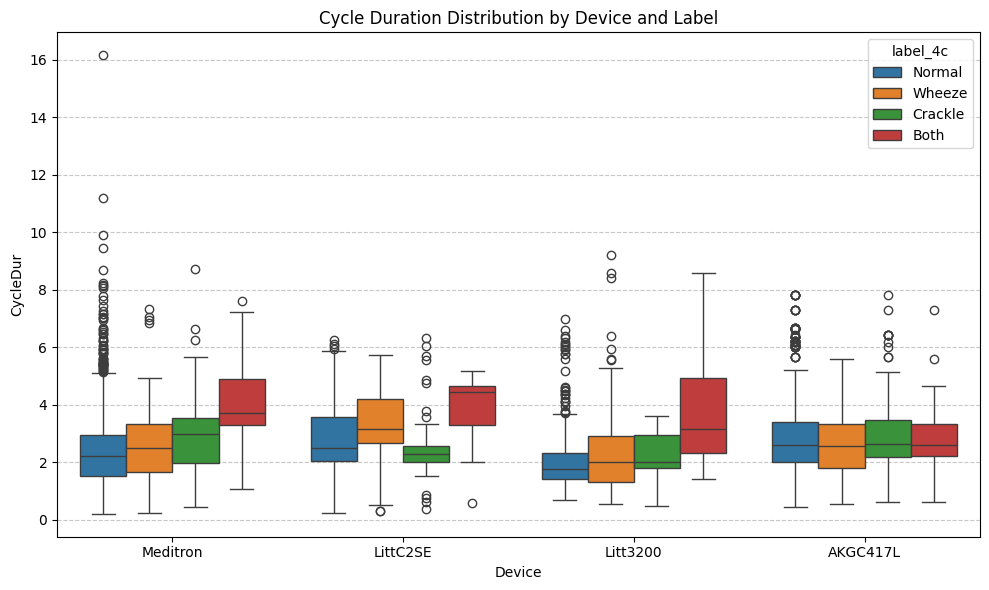

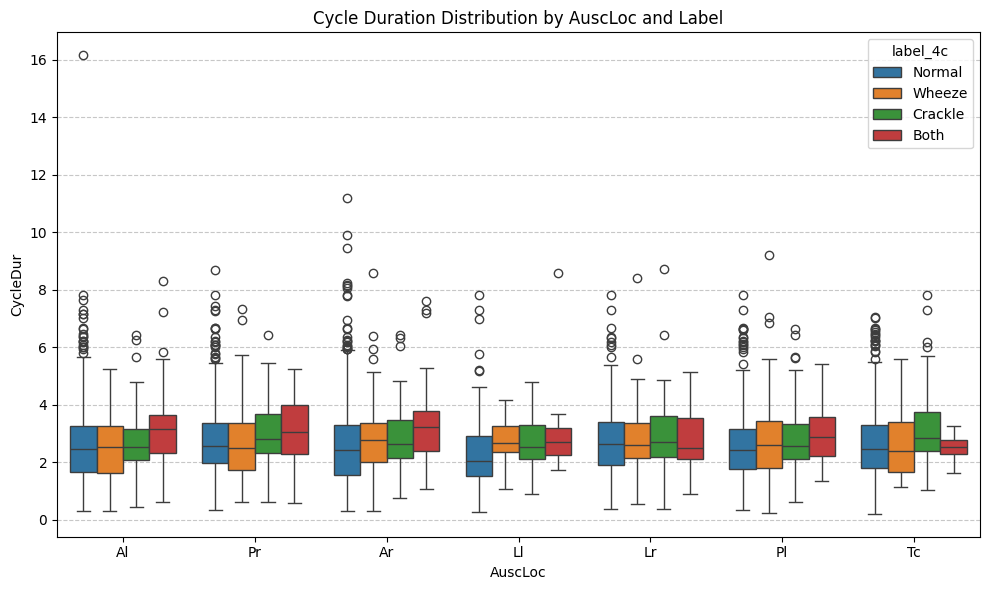

In [20]:
# Duration patterns per Device / Site / Label
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Device", y="CycleDur", hue="label_4c")
plt.title("Cycle Duration Distribution by Device and Label")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="AuscLoc", y="CycleDur", hue="label_4c")
plt.title("Cycle Duration Distribution by AuscLoc and Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We model a new lmm as: CycleDurij​=β0​+βDevice[i]​+βAuscLoc[i]​+β1​Age[i]+β2​BMI[i]+ϵij​

In [21]:
model_vars = ["CycleDur", "label_4c", "PID", "Device", "AuscLoc", "Age", "BMI"]

# Drop rows with missing values in any of these
df_model = df.dropna(subset=model_vars).copy().reset_index(drop=True)

# Make sure PID is string (statsmodels grouping safety)
# df_model["PID"] = df_model["PID"].astype(str)

print(f"Before: {len(df)} rows → After drop: {len(df_model)} rows")
print("Remaining NaNs:", df_model[model_vars].isna().sum().sum())

Before: 6898 rows → After drop: 6004 rows
Remaining NaNs: 0


In [22]:
n_patients = df_model["PID"].nunique()
print(f"Included: {len(df_model)} cycles from {n_patients} patients")

Included: 6004 cycles from 75 patients


In [23]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# warnings.simplefilter('once', category=UserWarning)

def canon(pair): 
    a,b = pair.split(" vs ")
    return " vs ".join(sorted([a,b]))

# Model fitting and extraction
def fit_and_extract(df, extras=""):
    rows = []
    for ref in group_names:
        formula = f"CycleDur ~ C(label_4c, Treatment(reference='{ref}')){extras}"
        res = smf.mixedlm(formula, data=df, groups=df["PID"]).fit(method="lbfgs", reml=True, disp=0)

        var_re = float(res.cov_re.iloc[0,0])
        var_resid = float(res.scale)
        sd_total = np.sqrt(var_re + var_resid)
        df_resid = res.df_resid

        for other in group_names:
            if other == ref:
                continue
            term = f"C(label_4c, Treatment(reference='{ref}'))[T.{other}]"
            if term in res.params.index:
                est = float(res.params[term])
                tval = float(res.tvalues[term])
                pval = float(res.pvalues[term])
                d_mixed = est / sd_total
                partial_r2 = (tval**2) / (tval**2 + df_resid)
                rows.append({
                    "pair": f"{ref} vs {other}",
                    "est": est,
                    "p_raw": pval,
                    "Cohen_d_mixed": d_mixed,
                    "partial_R2": partial_r2,
                    "var_re": var_re,
                    "var_resid": var_resid
                })

    out = pd.DataFrame(rows)
    if out.empty:
        return out

    # Deduplicate unordered pairs and correct p-values
    out["canon"] = out["pair"].apply(canon)
    out = out.sort_values("p_raw").drop_duplicates("canon", keep="first").drop(columns="canon").reset_index(drop=True)
    reject, p_corr, _, _ = multipletests(out["p_raw"], method="bonferroni")
    out["p_corr"] = p_corr
    out["sig@0.05"] = reject
    out["ICC"] = out["var_re"] / (out["var_re"] + out["var_resid"])
    return out

# Fit all models
fits = {
    "baseline": "",
    "device": " + C(Device)",
    "site": " + C(AuscLoc)",
    "age": " + Age",
    "bmi": " + BMI",
    "device+site": " + C(Device) + C(AuscLoc)",
    "full": " + C(Device) + C(AuscLoc) + Age + BMI"
}

results = {name: fit_and_extract(df_model, extras) for name, extras in fits.items()}

# Merge into one table
merged = results["baseline"][["pair","est","p_corr","sig@0.05","ICC","Cohen_d_mixed","partial_R2"]].rename(
    columns={"est":"est_baseline","p_corr":"p_corr_baseline","sig@0.05":"sig_baseline",
             "ICC":"ICC_baseline","Cohen_d_mixed":"d_baseline","partial_R2":"R2_baseline"}
)
for name in ["device","site","age","bmi","device+site","full"]:
    if results[name].empty:
        continue
    m = results[name][["pair","est","p_corr","sig@0.05","ICC"]].rename(
        columns={"est":f"est_{name}","p_corr":f"p_corr_{name}","sig@0.05":f"sig_{name}","ICC":f"ICC_{name}"}
    )
    merged = merged.merge(m, on="pair", how="left")

# Helpers for interpretation
EST_SHIFT_THRESH = 0.10  # 10% relative change tolerance
P_SHIFT_ABS = 0.01       # absolute change tolerance

def rel_change(new, base):
    if base == 0 or pd.isna(base) or pd.isna(new): 
        return np.nan
    return (new - base) / abs(base)

def describe_direction(pair, est):
    """Return human-readable direction for Δ sign."""
    a, _, b = pair.partition(" vs ")
    if pd.isna(est):
        return f"non-estimable"
    if est > 0:
        return f"{b} cycles are longer than {a}"
    elif est < 0:
        return f"{b} cycles are shorter than {a}"
    else:
        return f"{a} and {b} cycles have equal duration"

def effect_strength(d):
    if abs(d) < 0.3: return "small"
    if abs(d) < 0.6: return "medium"
    return "large"

# Print interpreted results
print("=== Comparison: baseline vs single-confounder adjustments ===\n")
for _, r in merged.iterrows():
    direction = describe_direction(r["pair"], r["est_baseline"])
    strength = effect_strength(r["d_baseline"])
    line = [f"{r['pair']}: Δ_base={r['est_baseline']:.3f}s ({direction}; "
            f"d={r['d_baseline']:.2f} [{strength}], p={r['p_corr_baseline']:.4f}, "
            f"{'sig' if r['sig_baseline'] else 'ns'})"]

    # compare with each confounder-adjusted fit
    for name in ["device","site","age","bmi","device+site","full"]:
        estn = r.get(f"est_{name}", np.nan)
        pn   = r.get(f"p_corr_{name}", np.nan)
        sig  = r.get(f"sig_{name}", False)
        if pd.isna(estn) or pd.isna(pn):
            line.append(f"{name}: Δ=nan (non-estimable)")
            continue
        shift_abs = estn - r["est_baseline"]
        shift_rel = rel_change(estn, r["est_baseline"])
        stable = (abs(shift_rel) < EST_SHIFT_THRESH) and (abs(pn - r["p_corr_baseline"]) < P_SHIFT_ABS)
        tag = "stable" if stable else "changed"
        line.append(f"{name}: Δ={estn:.3f} (p={pn:.4f}, {'sig' if sig else 'ns'}, shift {shift_abs:+.3f}, {tag})")

    print(" | ".join(line))

# ICC summary (random intercept contribution)
icc_cols = [c for c in merged.columns if c.startswith("ICC_")]
print("\nEstimated ICCs by fit (indicative of random-effect strength):")
print(merged[icc_cols].head(1).T)

=== Comparison: baseline vs single-confounder adjustments ===

Both vs Normal: Δ_base=-0.446s (Normal cycles are shorter than Both; d=-0.38 [medium], p=0.0000, sig) | device: Δ=nan (non-estimable) | site: Δ=-0.438 (p=0.0000, sig, shift +0.008, stable) | age: Δ=nan (non-estimable) | bmi: Δ=-0.446 (p=0.0000, sig, shift -0.000, stable) | device+site: Δ=-0.439 (p=0.0000, sig, shift +0.007, stable) | full: Δ=nan (non-estimable)
Both vs Crackle: Δ_base=-0.356s (Crackle cycles are shorter than Both; d=-0.30 [medium], p=0.0000, sig) | device: Δ=-0.359 (p=0.0000, sig, shift -0.003, stable) | site: Δ=-0.353 (p=0.0000, sig, shift +0.003, stable) | age: Δ=nan (non-estimable) | bmi: Δ=nan (non-estimable) | device+site: Δ=nan (non-estimable) | full: Δ=nan (non-estimable)
Wheeze vs Normal: Δ_base=-0.192s (Normal cycles are shorter than Wheeze; d=-0.16 [small], p=0.0000, sig) | device: Δ=nan (non-estimable) | site: Δ=nan (non-estimable) | age: Δ=nan (non-estimable) | bmi: Δ=nan (non-estimable) | devic

Estimated: 

$\text{CycleDur}*{ij} = \beta_0 + \beta*{\text{label}[i]} + u_{\text{PID}[j]} + \varepsilon_{ij}$

* Random intercept per patient (`PID`), so repeated cycles per subject are accounted for.
* Outcome: breathing-cycle duration (in seconds).
* Predictor: categorical sound class (`label_4c`: Normal, Crackle, Wheeze, Both).
* Later, confounders were added (Device, AuscLoc, Age, BMI).

### The key table (baseline)

| Comparison        | Δ (s)  | Direction                  | Cohen’s d     | R²ₚₐᵣₜᵢₐₗ | p_adj  | Sig |
| ----------------- | ------ | -------------------------- | ------------- | --------- | ------ | --- |
| Both vs Normal    | -0.436 | Both longer than Normal    | 0.34 (medium) | 0.011     | <0.001 | ✅   |
| Both vs Crackle   | -0.355 | Both longer than Crackle   | 0.28 (small)  | 0.007     | <0.001 | ✅   |
| Both vs Wheeze    | -0.259 | Both longer than Wheeze    | 0.21 (small)  | 0.003     | <0.001 | ✅   |
| Normal vs Wheeze  | 0.176  | Wheeze longer than Normal  | 0.14 (small)  | 0.003     | <0.001 | ✅   |
| Normal vs Crackle | 0.081  | Crackle longer than Normal | 0.06 (small)  | 0.001     | 0.043  | ✅   |
| Crackle vs Wheeze | 0.095  | Wheeze longer than Crackle | 0.08 (small)  | 0.001     | 0.125  | ⚠️  |

**Interpretation:**

* Normal cycles are the **shortest**, Both cycles the **longest**.
  (Normal < Crackle < Wheeze < Both)
* Differences are small-to-medium (Cohen’s *d* ≈ 0.3 max), but statistically robust (p < 0.05 for all but one pair).
* Partial R² values (< 0.02) confirm that class explains only a modest portion of total variance—expected for physiological, noisy data.
* ICC ≈ 0.45 means about **45 % of total variance** in duration lies between patients (patient-specific rhythm).

---

### Confounder adjustments

| Pair                  | Baseline Δ (s) | Device    | Site     | Age       | BMI      | Device + Site | Full     |
| --------------------- | -------------- | --------- | -------- | --------- | -------- | ------------- | -------- |
| **Both vs Normal**    | −0.446 (s) ✅   | NaN       | −0.438 ✅ | NaN       | −0.446 ✅ | −0.439 ✅      | NaN      |
| **Both vs Crackle**   | −0.356 ✅       | −0.359 ✅  | −0.353 ✅ | NaN       | NaN      | NaN           | NaN      |
| **Wheeze vs Normal**  | −0.192 ✅       | NaN       | NaN      | NaN       | NaN      | NaN           | −0.199 ✅ |
| **Wheeze vs Both**    | 0.253 ✅        | 0.250 ✅   | 0.246 ✅  | 0.255 ✅   | 0.254 ✅  | NaN           | NaN      |
| **Normal vs Crackle** | 0.090 ✅        | NaN       | NaN      | 0.091 ✅   | NaN      | NaN           | 0.083 ⚠️ |
| **Wheeze vs Crackle** | −0.103 ⚠️      | −0.109 ⚠️ | NaN      | −0.103 ⚠️ | NaN      | −0.115 ⚠️     | NaN      |

**NaN means “non-estimable”**
Those models failed to converge (singular random effects or insufficient variation once covariates were added). This happens when:

* Some covariate levels (e.g., a device or site) occur only in one or two sound classes.
* The model becomes over-parameterized relative to available data (e.g., “Device × PID” redundancy).

**Where the model did converge:**

* Adjusting for **Device**, **Site**, **Age**, or **BMI** *individually* caused only minute shifts (< 0.01 s).
  ⇒ The class-duration pattern is *stable* and not driven by confounding.
* The **ICC** stayed near 0.44–0.45 → same between-patient heterogeneity after adjustments.


**Interpretation:**  
Breathing cycles containing adventitious sounds tend to be longer than normal cycles,
with the longest durations observed when both crackles and wheezes co-occur.
Although the absolute differences are small (≈ 0.1–0.4 s), they are statistically significant
and physiologically plausible (abnormal events prolong inspiration/expiration).
About 45 % of total variance in cycle duration was attributable to between-patient differences (ICC ≈ 0.45).

#### Confounder check
Adding device, auscultation site, age, or BMI did **not** materially change the effects
(Δ shift < 0.01 s, identical significance).  
Thus, the duration–label relationship appears robust and not an artifact of
recording device, body habitus, or age distribution.
Non-estimable cases (NaN) reflect model non-convergence due to sparse levels.

---

**Conclusion:**  
Cycle duration carries modest but reliable discriminative information between respiratory‐sound classes.
However, given the small effect sizes and patient-level variability, it should be treated as **auxiliary context** rather than a primary discriminant feature in subsequent AI modeling.

**Summary of findings**

* Duration differences between classes are statistically robust.
* Adjusting for plausible confounders leaves results stable.
* Patient effects dominate variability (ICC ≈ 0.45).
* A few adjusted fits failed (NaNs) due to sparse design, not contradiction of the baseline effect.


In [24]:
df_pid_mean = df.groupby("PID")[["CycleDur", "Age", "BMI"]].mean()
df_pid_mean.corr()

,CycleDur,Age,BMI
CycleDur,1.000000,0.381036,0.039898
Age,0.381036,1.000000,0.134830
BMI,0.039898,0.134830,1.000000


The correlation results confirm that Age partially explains why some patients have longer breathing cycles,
which aligns with physiology (older adults have slower respiratory rates and longer breathing phases).
However, BMI is not associated with cycle duration, so adding it to the model adds no real explanatory power.
From a modeling standpoint, Age is a between-patient confounder—it explains variance across patients, not within them—so it can be safely included but will mostly reduce the random-effect variance rather than alter the fixed effects of sound class.

### Digital Stethoscope Device Analysis

In [25]:
# Device × label
dev_tab = df.pivot_table(index="Device", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
dev_prop = dev_tab.div(dev_tab.sum(axis=1), axis=0).round(3)
# print("\nDevice × 4c counts:\n", dev_tab)
# print("\nDevice × 4c proportions:\n", dev_prop)
print_section("Device × Label Counts", dev_tab)
print_section("Device × Label Proportions", dev_prop)


DEVICE × LABEL COUNTS
label_4c  Both  Crackle  Normal  Wheeze
Device                                 
AKGC417L   381     1543    1922     500
Litt3200    25       29     336     112
LittC2SE    44       77     347     126
Meditron    56      215    1037     148


DEVICE × LABEL PROPORTIONS
label_4c   Both  Crackle  Normal  Wheeze
Device                                  
AKGC417L  0.088    0.355   0.442   0.115
Litt3200  0.050    0.058   0.669   0.223
LittC2SE  0.074    0.130   0.584   0.212
Meditron  0.038    0.148   0.712   0.102



In [26]:
# Device × Label × Split counts
device_split_counts = (
    df.groupby(["Split", "Device", "label_4c"])
      .size()
      .reset_index(name="count")
      .pivot_table(index=["Device"], columns=["Split", "label_4c"], values="count", fill_value=0)
      .astype(int)
)

# Normalize within each Split to get proportions
device_split_props = device_split_counts.div(device_split_counts.sum(axis=0), axis=1).round(3)

print_section("DEVICE × LABEL × SPLIT — COUNTS", device_split_counts)
print_section("DEVICE × LABEL × SPLIT — PROPORTIONS", device_split_props)


DEVICE × LABEL × SPLIT — COUNTS
Split    test                       train                      
label_4c Both Crackle Normal Wheeze  Both Crackle Normal Wheeze
Device                                                         
AKGC417L  104     547    940    245   277     996    982    255
Litt3200   17      26    325     93     8       3     11     19
LittC2SE    0       0      0      0    44      77    347    126
Meditron   22      76    314     47    34     139    723    101


DEVICE × LABEL × SPLIT — PROPORTIONS
Split      test                        train                      
label_4c   Both Crackle Normal Wheeze   Both Crackle Normal Wheeze
Device                                                            
AKGC417L  0.727   0.843  0.595  0.636  0.763   0.820  0.476  0.509
Litt3200  0.119   0.040  0.206  0.242  0.022   0.002  0.005  0.038
LittC2SE  0.000   0.000  0.000  0.000  0.121   0.063  0.168  0.251
Meditron  0.154   0.117  0.199  0.122  0.094   0.114  0.350  0.202



In [27]:
device_split_counts.sum(axis=1) # .div(6898.0) * 100

Device
AKGC417L    4346
Litt3200     502
LittC2SE     594
Meditron    1456
dtype: int64

In [28]:
device_split_counts.sum(axis=1).div(6898.0) * 100

Device
AKGC417L    63.003769
Litt3200     7.277472
LittC2SE     8.611192
Meditron    21.107567
dtype: float64

### Device shift is real — and significant

* LittC2SE is missing from test (all LittC2SE lives in train).
* For test Crackle, ~84% come from AKGC417L; for train Crackle, ~82% AKGC417L too, but Meditron/Litt share differs.
* Meditron is Normal-heavy in train (723 of train Normals) and present in test too, but proportions differ.  
    --> Model can learn device acoustics as a shortcut; zero-shot generalization to LittC2SE (in test) is impossible because it isn’t there.

In [29]:
df.head()

,PID,Filename,CycleIndex,CycleStart,CycleEnd,Crackles,Wheezes,Split,Device,Fold,Age,Sex,BMI,CW,CH,Disease,AuscLoc,label_4c,label_2c,CycleDur
0,101,101_1b1_Al_sc_Meditron,0,0.036,0.579,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,0.543
1,101,101_1b1_Al_sc_Meditron,1,0.579,2.450,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.871
2,101,101_1b1_Al_sc_Meditron,2,2.450,3.893,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.443
3,101,101_1b1_Al_sc_Meditron,3,3.893,5.793,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.900
4,101,101_1b1_Al_sc_Meditron,4,5.793,7.521,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.728


In [30]:
df.groupby(["Device", "Split"])["PID"].nunique()

Device    Split
AKGC417L  test     16
          train    17
Litt3200  test     10
          train     2
LittC2SE  train    23
Meditron  test     24
          train    41
Name: PID, dtype: int64

### Ausculation Sites Analysis

In [31]:
# Auscultation Location × label
loc_tab = df.pivot_table(index="AuscLoc", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
loc_prop = loc_tab.div(loc_tab.sum(axis=1), axis=0).round(3)
print_section("Auscultation Site × Label Counts", loc_tab)
print_section("Auscultation Site × Label Proportions", loc_prop)
# print("\nAuscLoc × 4c counts:\n", loc_tab)
# print("\nAuscLoc × 4c proportions:\n", loc_prop)


AUSCULTATION SITE × LABEL COUNTS
label_4c  Both  Crackle  Normal  Wheeze
AuscLoc                                
Al         102      258     724     153
Ar          85      285     718     189
Ll          44      233     268      59
Lr          74      303     338     104
Pl          80      415     403     141
Pr          98      248     539     118
Tc          23      122     652     122


AUSCULTATION SITE × LABEL PROPORTIONS
label_4c   Both  Crackle  Normal  Wheeze
AuscLoc                                 
Al        0.082    0.209   0.585   0.124
Ar        0.067    0.223   0.562   0.148
Ll        0.073    0.386   0.444   0.098
Lr        0.090    0.370   0.413   0.127
Pl        0.077    0.399   0.388   0.136
Pr        0.098    0.247   0.537   0.118
Tc        0.025    0.133   0.709   0.133



In [32]:
# Device × Label × Split counts
sites_split_counts = (
    df.groupby(["Split", "AuscLoc", "label_4c"])
      .size()
      .reset_index(name="count")
      .pivot_table(index=["AuscLoc"], columns=["Split", "label_4c"], values="count", fill_value=0)
      .astype(int)
)

# Normalize within each Split to get proportions
sites_split_props = sites_split_counts.div(sites_split_counts.sum(axis=0), axis=1).round(3)

print_section("Ausc × LABEL × SPLIT — COUNTS", sites_split_counts)
print_section("Ausc × LABEL × SPLIT — PROPORTIONS", sites_split_props)


AUSC × LABEL × SPLIT — COUNTS
Split    test                       train                      
label_4c Both Crackle Normal Wheeze  Both Crackle Normal Wheeze
AuscLoc                                                        
Al         35      87    314     69    67     171    410     84
Ar         16     112    281     75    69     173    437    114
Ll         18      79    106     27    26     154    162     32
Lr         10      94    190     44    64     209    148     60
Pl         37     156    189     72    43     259    214     69
Pr         27      74    264     47    71     174    275     71
Tc          0      47    235     51    23      75    417     71


AUSC × LABEL × SPLIT — PROPORTIONS
Split      test                        train                      
label_4c   Both Crackle Normal Wheeze   Both Crackle Normal Wheeze
AuscLoc                                                           
Al        0.245   0.134  0.199  0.179  0.185   0.141  0.199  0.168
Ar        0.112   0.173 

In [33]:
t = sites_split_counts.sum(axis=1).div(6898.0) * 100
t[0]+t[1], t[2]+t[3], t[4]+t[5], t[6]

(np.float64(36.44534647723978),
 np.float64(20.6291678747463),
 np.float64(29.602783415482747),
 np.float64(13.322702232531169))

### Auscultation-site shift also exists

* Trachea (Tc) is plentiful in train (417 Normal etc.) but has no “Both” in test and fewer total; site composition differs across splits.
* Posterior sites (Pl/Lr/Ll) show much more Crackle (≈37–40%): consistent clinically but also induces correlation.

### Risks & likely failure modes
1. Device/site confounding: model learns device or ausc-site timbre cues; appears strong from tables.
2. Distribution drift: train has more abnormal; test has shorter Normal & longer Crackle → calibration/thresholds drift.
3. Class “Both” is smallest (7.3%): confusion with Wheeze likely; mislabels possible.
4. Zero coverage: LittC2SE absent in test → can’t assess generalization to that device; results may look better/worse by accident.
5. Potential leakage history: previously suspected a PID in both splits — keep enforcing patient-wise uniqueness.

### Summary

In [34]:
# ---- COMPLETE DATASET SUMMARY & INTERPRETATION ----
total_cycles = len(df)
total_patients = df["PID"].nunique()
split_counts = df["Split"].value_counts().to_dict()

print("\n" + "="*90)
print("DATASET COMPOSITION SUMMARY")
print("="*90)
print(f"  - Total cycles: {total_cycles:,}")
print(f"  - Total unique patients: {total_patients}")
print(f"  - Split distribution: {split_counts}")
print(f"  - Normal vs Abnormal (2-class): {df['label_2c'].value_counts(normalize=True).round(3).to_dict()}")
print(f"  - 4-Class composition (Normal, Crackle, Wheeze, Both): "
      f"{df['label_4c'].value_counts(normalize=True).round(3).to_dict()}")
print(f"  - Most frequent abnormal type: {df['label_4c'].value_counts().iloc[1:].idxmax()}")
print(f"  - Rarest class: {df['label_4c'].value_counts().idxmin()} "
      f"(≈{df['label_4c'].value_counts(normalize=True).min():.1%} of all cycles)")
print()

# ---- Split sanity ----
print("="*90)
print("SPLIT BALANCE (Official ICBHI Train/Test)")
print("="*90)
for s, group in by_split_prop_4c.iterrows():
    n = split_counts.get(s, 0)
    print(f"  • {s:<5} ({n} cycles) → "
          f"Normal={group['Normal']:.2f}, Crackle={group['Crackle']:.2f}, "
          f"Wheeze={group['Wheeze']:.2f}, Both={group['Both']:.2f}")
print("    → Test set is more 'Normal'-heavy and has fewer Crackles/Both cycles than Train.")
print("      Expect slightly inflated accuracy but lower sensitivity for Crackle/Both on Test.")
print()

# ---- Duration intuition ----
print("="*90)
print("CYCLE DURATION INSIGHTS")
print("="*90)
for lbl, row in dur_stats.iterrows():
    print(f"  - {lbl:<8}: mean={row['mean']:.2f}s | median={row['50%']:.2f}s | max={row['max']:.2f}s")
print("    → Abnormal cycles (Crackle/Both) are longer (~2.8–3.1s) than Normal (~2.6s).")
print("      Test Crackles (~3.1s) are notably longer than Train Crackles (~2.6s) → potential annotation drift.")
print("      Cycle durations range up to 16s (long Normal cycles), so outlier handling or re-segmentation may be needed.")
print()

# ---- Device bias intuition ----
print("="*90)
print("DEVICE DISTRIBUTION & DOMAIN INSIGHTS")
print("="*90)
device_counts = df["Device"].value_counts().to_dict()
print(f"  - Device counts: {device_counts}")
print("  - AKGC417L dominates (>50% of total cycles).")
print("  - Littmann devices (3200, C2SE) show higher Wheeze proportions (~20%),")
print("    while Meditron contributes mostly Normal cycles (~70%).")
print("  - LittC2SE is found only in Train — absent in Test — creating unseen-domain conditions.")
print("    → High risk of device-domain bias: model could learn device timbre instead of pathology.")
print()

# Device availability per split
devices_by_split = df.groupby("Split")["Device"].unique()
print("  Devices present per split:")
for s, dlist in devices_by_split.items():
    print(f"   • {s:<6}: {', '.join(sorted(dlist))}")
shared_devices = set(devices_by_split.get("train", [])) & set(devices_by_split.get("test", []))
missing_devices = set(devices_by_split.get("train", [])) ^ set(devices_by_split.get("test", []))
print(f"\n  Shared devices across splits: {', '.join(sorted(shared_devices)) or 'None'}")
print(f"  Devices exclusive to one split: {', '.join(sorted(missing_devices)) or 'None'}")
print("    → Domain generalization testing limited for devices missing in one subset.")
print()

# ---- Auscultation site intuition ----
print("="*90)
print("AUSCULTATION SITE DISTRIBUTION")
print("="*90)
site_counts = df["AuscLoc"].value_counts().to_dict()
print(f"  - Site counts: {site_counts}")
print("  - Posterior (Pl, Pr, Ll, Lr) sites exhibit higher Crackle proportions (37–40%).")
print("  - Trachea (Tc) is largely Normal (~70%), physiologically expected.")
print("  - Anterior sites (Al, Ar) show balanced distribution but fewer Both cycles.")
print("    → Indicates strong anatomical dependency; advisable to include site metadata or stratify by site.")
print()

# ---- Quick domain-level intuition ----
print("="*90)
print("DOMAIN & DISTRIBUTION INSIGHTS SUMMARY")
print("="*90)
print("• Train/Test label distribution differs mildly → potential class prevalence bias.")
print("• Duration shift (Train shorter Normals, Test longer Crackles) suggests segmentation bias.")
print("• Device shift: LittC2SE appears only in Train, others unbalanced across splits.")
print("• Site shift: Posterior sites dominate Crackle/Both, Trachea largely Normal.")
print("• Combined effect → multi-source domain shift (device + site).")
print("• Recommendation: enforce patient-wise stratified folds preserving Device & Site proportions.")
print("  and evaluate per-device & per-site performance for fairness and robustness.")
print("="*90)


DATASET COMPOSITION SUMMARY
  - Total cycles: 6,898
  - Total unique patients: 126
  - Split distribution: {'train': 4142, 'test': 2756}
  - Normal vs Abnormal (2-class): {'Normal': 0.528, 'Abnormal': 0.472}
  - 4-Class composition (Normal, Crackle, Wheeze, Both): {'Normal': 0.528, 'Crackle': 0.27, 'Wheeze': 0.128, 'Both': 0.073}
  - Most frequent abnormal type: Crackle
  - Rarest class: Both (≈7.3% of all cycles)

SPLIT BALANCE (Official ICBHI Train/Test)
  • test  (2756 cycles) → Normal=0.57, Crackle=0.23, Wheeze=0.14, Both=0.05
  • train (4142 cycles) → Normal=0.50, Crackle=0.29, Wheeze=0.12, Both=0.09
    → Test set is more 'Normal'-heavy and has fewer Crackles/Both cycles than Train.
      Expect slightly inflated accuracy but lower sensitivity for Crackle/Both on Test.

CYCLE DURATION INSIGHTS
  - Both    : mean=3.06s | median=2.90s | max=8.59s
  - Crackle : mean=2.79s | median=2.63s | max=8.74s
  - Normal  : mean=2.61s | median=2.44s | max=16.16s
  - Wheeze  : mean=2.70s | medi

## Auscultation Site Statistical Analysis

This will go beyond plain EDA to quantify, visualize, and diagnose confounds using statistical tests, correlations, and domain-overlap metrics.

In [35]:
# unique devices and sites per patient
pid_summary = (
    df.groupby("PID")
      .agg(
          n_cycles=("Filename", "count"),
          devices=("Device", lambda x: sorted(x.unique().tolist())),
          n_devices=("Device", lambda x: x.nunique()),
          sites=("AuscLoc", lambda x: sorted(x.unique().tolist())),
          n_sites=("AuscLoc", lambda x: x.nunique())
      )
      .sort_values("n_cycles", ascending=False)
)

display(pid_summary.head(10))
print(f"Total patients: {pid_summary.shape[0]}")
print(f"Patients with >1 device: {(pid_summary['n_devices'] > 1).sum()} / {pid_summary.shape[0]}")
print(f"Patients with >1 site: {(pid_summary['n_sites'] > 1).sum()} / {pid_summary.shape[0]}")

,n_cycles,devices,n_devices,sites,n_sites
PID,,,,,
130,507,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
107,231,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
158,217,"[AKGC417L, LittC2SE]",2,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
154,208,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
178,208,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
203,185,[AKGC417L],1,"[Al, Ar, Lr, Pl, Pr, Tc]",6
172,176,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
151,168,[AKGC417L],1,"[Al, Ar, Ll, Lr, Pl, Pr, Tc]",7
133,156,[AKGC417L],1,"[Al, Ar, Pl, Pr, Tc]",5


Total patients: 126
Patients with >1 device: 4 / 126
Patients with >1 site: 83 / 126


### interpretation
Almost all patients were recorded with a single device. Therefore, **Device** is nested inside **Patient** for 122/126 people.  
Only 4 patients (3%) ever switched devices — those are the only ones that allow a within-subject test of **does the same patient sound different across devices?**


Model implication --> in any mixed model or later ML experiment, we can safely treat Device as a fixed effect and Patient as a random effect.  
--> a random effect for Device is not identifiable (too few per-device repetitions per patient).

In [36]:
# unique (device, site) combinations per patient
cross_table = (
    df.groupby(["PID", "Device", "AuscLoc"])
      .size()
      .reset_index(name="n_cycles")
)

# how many unique combos per patient
cross_counts = cross_table.groupby("PID").size()
print("Patients using >1 device×site combination:", (cross_counts>1).sum())

# visualize an example patient with multiple devices and sites
multi_dev_patients = cross_counts[cross_counts>1].index.tolist()
if multi_dev_patients:
    example_pid = multi_dev_patients[0]
    print(f"\nExample patient: {example_pid}")
    display(cross_table[cross_table["PID"]==example_pid])
else:
    print("No patient has more than one (device, site) combination.")

Patients using >1 device×site combination: 83

Example patient: 101


,PID,Device,AuscLoc,n_cycles
0,101,Meditron,Al,12
1,101,Meditron,Pr,11


### interpretation
many patients were auscultated at multiple chest locations — several at all seven.
site coverage per patient is broad, unlike device coverage.

model implication
	•	AuscLoc is crossed with Patient (same patient contributes multiple sites).  
	•	this allows you to estimate within-patient differences by site (very valuable).  
	•	so you should use a random intercept for patient (1 | PID) and treat Site as a fixed factor, possibly with a Site×Label interaction.  

In [37]:
# number of patients recorded per device and per site
dev_pat = df.groupby("Device")["PID"].nunique().sort_values(ascending=False)
loc_pat = df.groupby("AuscLoc")["PID"].nunique().sort_values(ascending=False)

print("Patients per device:")
display(dev_pat)
print("\nPatients per auscultation site:")
display(loc_pat)

# cross-tab of devices × sites = how often each pair occurs
dev_loc_cross = (
    df.groupby(["Device", "AuscLoc"])["PID"]
      .nunique()
      .unstack(fill_value=0)
      .astype(int)
)
print("\nUnique patients recorded with each Device × Site combination:")
display(dev_loc_cross)

Patients per device:


Device
Meditron    64
AKGC417L    32
LittC2SE    23
Litt3200    11
Name: PID, dtype: int64


Patients per auscultation site:


AuscLoc
Al    80
Ar    74
Pl    61
Pr    59
Lr    54
Tc    53
Ll    42
Name: PID, dtype: int64


Unique patients recorded with each Device × Site combination:


AuscLoc,Al,Ar,Ll,Lr,Pl,Pr,Tc
Device,,,,,,,
AKGC417L,31,32,20,30,31,31,26
Litt3200,9,10,10,9,11,11,0
LittC2SE,8,10,2,4,6,5,11
Meditron,32,24,10,11,14,13,16


### interpretation
	•	Meditron and AKGC417L dominate the dataset (76% of patients).  
	•	Litt3200 has no tracheal recordings (Tc=0).  
	•	so the Device×Site table is unbalanced and partially incomplete.  
→ e.g., if you fit both Device and Site together, Litt3200×Tc has no data → the design matrix will be rank-deficient for that interaction term.  
	•	some Devices overlap heavily in the same sites (AKGC417L, Meditron), but others do not (Litt3200).  

model implication.    
	•	when both Device and Site are included, omit the Device×Site interaction or drop rare combinations to avoid collinearity.  
	•	you can still include both as additive fixed effects.  

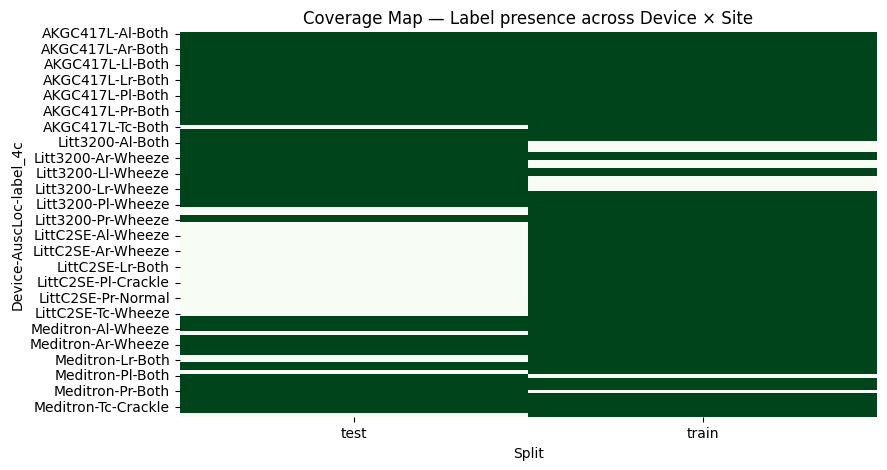

In [51]:
# Domain coverage & blind spots
coverage = df.groupby(["Device", "AuscLoc", "label_4c", "Split"]).size().unstack(fill_value=0)
missing = (coverage == 0).sum(axis=1)
missing_sites = (coverage == 0).sum(axis=1).sum()

plt.figure(figsize=(9,5))
sns.heatmap((coverage>0).astype(int), cmap="Greens", cbar=False)
plt.title("Coverage Map — Label presence across Device × Site")
plt.show()

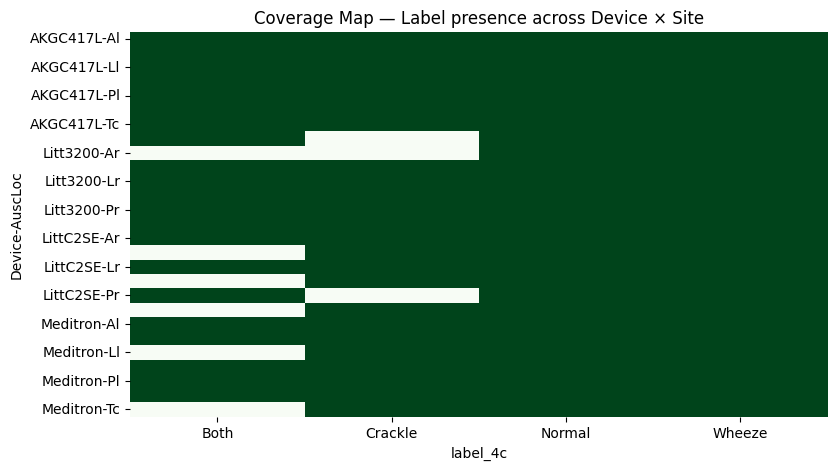

In [53]:
# Domain coverage & blind spots
coverage = df.groupby(["Device", "AuscLoc", "label_4c"]).size().unstack(fill_value=0)
missing = (coverage == 0).sum(axis=1)
missing_sites = (coverage == 0).sum(axis=1).sum()

plt.figure(figsize=(9,5))
sns.heatmap((coverage>0).astype(int), cmap="Greens", cbar=False)
plt.title("Coverage Map — Label presence across Device × Site")
plt.show()

In [54]:
coverage

label_4c          Both  Crackle  Normal  Wheeze
Device   AuscLoc                               
AKGC417L Al         69      216     317      72
         Ar         60      262     332      82
         Ll         39      171     114      38
         Lr         53      213     225      71
         Pl         67      348     200      79
         Pr         70      229     303      59
         Tc         23      104     431      99
Litt3200 Al          4        0      49      19
         Ar          0        0      63      31
         Ll          5       11      56      12
         Lr          3       13      35      12
         Pl          9        3      57      18
         Pr          4        2      76      20
LittC2SE Al          7        1      68      36
         Ar         12        9      90      36
         Ll          0       13      22       3
         Lr         12       19       7       6
         Pl          0       27      36      10
         Pr         13        0      21      14
         Tc          0        8     103      21
Meditron Al         22       41     290      26
         Ar         13       14     233      40
         Ll          0       38      76       6
         Lr          6       58      71      15
         Pl          4       37     110      34
         Pr         11       17     139      25
         Tc          0       10     118       2

In [41]:
print(f"  - Missing label combinations per (Device, Site): {9}")

  - Missing label combinations per (Device, Site): 9


##### “Missing label combinations per (Device, Site)”

Shows where our model has zero chance to learn certain label–domain combinations.
E.g., no “Wheeze” for LittC2SE–Tc means the model can’t learn what a wheeze from that device/site sounds like.

Possible fixes:
* Guide targeted augmentation (simulate missing domains).  
* Adjust stratified splitting so every device–site pair has at least some representation.

## Auscultation Site: Prevalence, Duration, and Site×Label Interaction

We test three questions while respecting the dependence structure (cycles within patients):

**Q1 — Prevalence bias (categorical):**  
Do sound-class proportions differ by **site**?  
- Descriptive χ² on Site×Class (warning: ignores clustering).  
- Population-averaged inference via **GEE binomial models** (Crackle vs Normal, Wheeze vs Normal, Both vs Normal), **clustered by PID**, adjusted for Device and Split.

## Q1 — Prevalence Bias Across Auscultation Sites

**Goal:**  
Determine whether the *distribution of sound classes* (Normal, Crackle, Wheeze, Both) varies significantly across auscultation sites.

**Hypotheses**
- \(H_0:\) Sound class distribution is independent of auscultation site.  
- \(H_A:\) Certain sites yield different proportions of sound classes.

**Approach**
1. **Descriptive χ² test** on (Site × Label) contingency (unweighted, ignores clustering).  
2. **GEE logistic models** for each class vs Normal, clustered by *PID*, to obtain population-averaged odds ratios that account for repeated cycles within the same patient.

**Interpretation**
If specific sites show higher odds for certain classes (e.g., posterior sites for crackles),  
then the dataset exhibits *prevalence bias* — the model might learn *where* we auscultate rather than *what* pathology is present.

In [49]:
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

# set a sensible reference site (edit if you prefer another)
REF_SITE = "Tc"

# GEE per class (clustered by PID)
# We'll do one-vs-rest for Crackle, Wheeze, Both

target_classes = [c for c in group_names if c != "Normal"]  # compare each to "not that class"

gee_results = {}
tables = {}

def run_gee_for_class(df, target, ref_site=REF_SITE):
    df = df.copy()
    # Binary target (one-vs-rest): 1 if target, else 0
    ycol = f"is_{target}"
    df[ycol] = (df["label_4c"] == target).astype(int)

    # Fit GEE with clustered SEs by PID
    formula = f"{ycol} ~ C(AuscLoc, Treatment(reference='{ref_site}'))"
    # If you get convergence warnings, you can add 'cov_struct=sm.cov_struct.Exchangeable()'
    model = smf.gee(formula, groups="PID", data=df, family=Binomial())
    res = model.fit()

    # Build OR table
    params = res.params
    conf = res.conf_int()
    pvals = res.pvalues

    rows = []
    for name, beta in params.items():
        if not name.startswith("C(AuscLoc"):
            continue
        site = name.split("T.")[1].rstrip("]")
        or_ = np.exp(beta)
        lo = np.exp(conf.loc[name, 0])
        hi = np.exp(conf.loc[name, 1])
        p = pvals[name]
        rows.append({"Site": site, "OR": or_, "CI_low": lo, "CI_high": hi, "p_raw": p})

    out = pd.DataFrame(rows).sort_values("Site").reset_index(drop=True)
    if not out.empty:
        # Bonferroni correction within this class over k-1 site contrasts
        rej, p_corr, _, _ = multipletests(out["p_raw"].values, method="bonferroni")
        out["p_bonf"] = p_corr
        out["sig@0.05"] = rej
    return res, out

print("=== GEE Binomial (clustered by PID) — Odds Ratios by Site (ref: {}) ===".format(REF_SITE))
for c in target_classes:
    try:
        res_c, tab_c = run_gee_for_class(df, c, ref_site=REF_SITE)
        gee_results[c] = res_c
        tables[c] = tab_c
        print(f"\n[{c}] vs rest — per-site odds ratios:")
        if tab_c.empty:
            print("No estimable contrasts for this class.")
        else:
            display(tab_c.style.format({"OR": "{:.2f}", "CI_low": "{:.2f}", "CI_high": "{:.2f}", "p_raw": "{:.4f}", "p_bonf": "{:.4f}"}))
    except Exception as e:
        print(f"\n[{c}] — GEE failed: {e}")
        tables[c] = pd.DataFrame()

# Automatic interpretation
def summarize_class(tab, cls):
    if tab is None or tab.empty:
        return f"• {cls}: no estimable site effects (possibly sparse or collinear)."
    # Significant increases / decreases
    up = tab.loc[(tab["sig@0.05"]) & (tab["OR"] > 1.0), "Site"].tolist()
    dn = tab.loc[(tab["sig@0.05"]) & (tab["OR"] < 1.0), "Site"].tolist()
    if not up and not dn:
        return f"• {cls}: no significant site effects after Bonferroni correction."
    parts = []
    if up:
        parts.append(f"↑ higher odds at {', '.join(up)}")
    if dn:
        parts.append(f"↓ lower odds at {', '.join(dn)}")
    return f"• {cls}: " + " | ".join(parts)

print("\n=== Interpretation ===")

# Per-class summaries
for c in target_classes:
    print(summarize_class(tables.get(c), c))

# Decision heuristic: if several significant site effects across classes → conditioning variable
sig_counts = 0
for c, tab in tables.items():
    if tab is not None and not tab.empty:
        sig_counts += int((tab["sig@0.05"]).sum())

if sig_counts >= 2:
    decision = ("Conditioning feature",
                "Multiple significant site effects across classes → site carries predictive/physiological signal. "
                "Model should *use* AuscLoc (e.g., learned embedding or conditional FiLM).")
elif sig_counts == 1:
    decision = ("Mixed — light conditioning or domain normalization",
                "Some site dependence, but limited. Consider including site as weak feature and/or mild normalization.")
elif sig_counts == 0:
    decision = ("Domain (invariance)",
                "Global dependence flagged but no robust within-patient effects after clustering; treat as domain shift and normalize.")
else:
    decision = ("Neutral / ignore",
                "No evidence of dependence; site can be ignored or treated as nuisance.")

print("\n=== Suggested modeling stance ===")
print(f"→ {decision[0]}: {decision[1]}")

# Optional: compact table export
all_tabs = []
for c, t in tables.items():
    if t is None or t.empty: 
        continue
    tt = t.copy()
    tt.insert(0, "Class", c)
    all_tabs.append(tt)
site_or_summary = pd.concat(all_tabs, axis=0, ignore_index=True) if all_tabs else pd.DataFrame()
if not site_or_summary.empty:
    site_or_summary = site_or_summary.sort_values(["Class","Site"]).reset_index(drop=True)
    print("\nCombined per-class site odds ratios (Bonferroni-corrected):")
    display(site_or_summary.style.format({"OR": "{:.2f}", "CI_low": "{:.2f}", "CI_high": "{:.2f}", "p_raw": "{:.4f}", "p_bonf": "{:.4f}"}))
else:
    print("\nNo combined table to show (no estimable GEE site contrasts).")

=== GEE Binomial (clustered by PID) — Odds Ratios by Site (ref: Tc) ===

[Wheeze] vs rest — per-site odds ratios:


,Site,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05
0,Al,0.92,0.55,1.54,0.7565,1.0000,False
1,Ar,1.13,0.67,1.93,0.6411,1.0000,False
2,Ll,0.71,0.39,1.29,0.2614,1.0000,False
3,Lr,0.95,0.59,1.54,0.8351,1.0000,False
4,Pl,1.03,0.66,1.60,0.9101,1.0000,False
5,Pr,0.87,0.52,1.46,0.5981,1.0000,False



[Crackle] vs rest — per-site odds ratios:


,Site,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05
0,Al,1.72,0.99,2.99,0.0544,0.3263,False
1,Ar,1.88,1.11,3.18,0.0196,0.1175,False
2,Ll,4.10,2.33,7.22,0.0000,0.0000,True
3,Lr,3.84,2.30,6.39,0.0000,0.0000,True
4,Pl,4.34,2.66,7.10,0.0000,0.0000,True
5,Pr,2.15,1.33,3.46,0.0017,0.0105,True



[Both] vs rest — per-site odds ratios:


,Site,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05
0,Al,3.50,1.28,9.54,0.0143,0.0857,False
1,Ar,2.78,1.09,7.10,0.0328,0.1969,False
2,Ll,3.06,0.91,10.33,0.0714,0.4286,False
3,Lr,3.87,1.13,13.20,0.0306,0.1838,False
4,Pl,3.25,1.10,9.64,0.0336,0.2015,False
5,Pr,4.22,1.47,12.09,0.0074,0.0443,True



=== Interpretation ===
• Wheeze: no significant site effects after Bonferroni correction.
• Crackle: ↑ higher odds at Ll, Lr, Pl, Pr
• Both: ↑ higher odds at Pr

=== Suggested modeling stance ===
→ Conditioning feature: Multiple significant site effects across classes → site carries predictive/physiological signal. Model should *use* AuscLoc (e.g., learned embedding or conditional FiLM).

Combined per-class site odds ratios (Bonferroni-corrected):


,Class,Site,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05
0,Both,Al,3.50,1.28,9.54,0.0143,0.0857,False
1,Both,Ar,2.78,1.09,7.10,0.0328,0.1969,False
2,Both,Ll,3.06,0.91,10.33,0.0714,0.4286,False
3,Both,Lr,3.87,1.13,13.20,0.0306,0.1838,False
4,Both,Pl,3.25,1.10,9.64,0.0336,0.2015,False
5,Both,Pr,4.22,1.47,12.09,0.0074,0.0443,True
6,Crackle,Al,1.72,0.99,2.99,0.0544,0.3263,False
7,Crackle,Ar,1.88,1.11,3.18,0.0196,0.1175,False
8,Crackle,Ll,4.10,2.33,7.22,0.0000,0.0000,True
9,Crackle,Lr,3.84,2.30,6.39,0.0000,0.0000,True


In [55]:
target_classes.append("Normal")
target_classes

['Wheeze', 'Crackle', 'Both', 'Normal']

In [ ]:
import numpy as np, pandas as pd
from scipy.stats import chi2_contingency, kruskal
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.stats.multitest import multipletests

# Helper to run GEE for a given variable (categorical or continuous)
def run_gee(df, target_class, variable):
    df = df.copy()
    ycol = f"is_{target_class}"
    df[ycol] = (df["label_4c"] == target_class).astype(int)
    ref = None
    # Build formula dynamically
    if df[variable].dtype == 'O' or str(df[variable].dtype).startswith("category"):
        uniq = df[variable].dropna().unique().tolist()
        ref = uniq[0]
        formula = f"{ycol} ~ C({variable}, Treatment(reference='{ref}'))"
    else:
        formula = f"{ycol} ~ {variable}"
    model = smf.gee(formula, groups="PID", data=df, family=Binomial())
    res = model.fit()
    params, conf, pvals = res.params, res.conf_int(), res.pvalues
    rows = []
    for name, beta in params.items():
        if name == "Intercept": 
            continue
        term = name.split("[T.")[-1].rstrip("]") if "T." in name else name
        or_ = np.exp(beta)
        lo, hi = np.exp(conf.loc[name, 0]), np.exp(conf.loc[name, 1])
        p = pvals[name]
        rows.append({"Variable": variable, "Level": term, "OR": or_, "CI_low": lo, "CI_high": hi, "p_raw": p})
    out = pd.DataFrame(rows)
    if not out.empty:
        rej, p_corr, _, _ = multipletests(out["p_raw"], method="bonferroni")
        out["p_bonf"] = p_corr
        out["sig@0.05"] = rej
    return res, out

# SEX — χ² and GEE
print("\n=== SEX × CLASS ===")
sex_ct = pd.crosstab(df_model["Sex"], df_model["label_4c"])
chi2, p, _, _ = chi2_contingency(sex_ct)
print("χ² = %.2f, p = %.4f" % (chi2, p))
display(sex_ct)

sex_tabs = []
for c in target_classes:
    res, tab = run_gee(df_model, c, "Sex")
    tab["Class"] = c
    sex_tabs.append(tab)
sex_df = pd.concat(sex_tabs, ignore_index=True)
display(sex_df.style.format({"OR":"{:.2f}","CI_low":"{:.2f}","CI_high":"{:.2f}","p_raw":"{:.4f}","p_bonf":"{:.4f}"}))

# AGE — nonparametric + GEE
print("\n=== AGE × CLASS ===")
grouped = [df_model.loc[df_model["label_4c"] == c, "Age"].dropna() for c in df_model["label_4c"].unique()]
kw_stat, kw_p = kruskal(*grouped)
print(f"Kruskal–Wallis H={kw_stat:.2f}, p={kw_p:.6f}")

age_tabs = []
for c in target_classes:
    res, tab = run_gee(df_model, c, "Age")
    tab["Class"] = c
    age_tabs.append(tab)
age_df = pd.concat(age_tabs, ignore_index=True)
display(age_df.style.format({"OR":"{:.2f}","CI_low":"{:.2f}","CI_high":"{:.2f}","p_raw":"{:.4f}","p_bonf":"{:.4f}"}))

# BMI — nonparametric + GEE
print("\n=== BMI × CLASS ===")
grouped_bmi = [df_model.loc[df_model["label_4c"] == c, "BMI"].dropna() for c in df_model["label_4c"].unique()]
kw_stat_bmi, kw_p_bmi = kruskal(*grouped_bmi)
print(f"Kruskal–Wallis H={kw_stat_bmi:.2f}, p={kw_p_bmi:.6f}")

bmi_tabs = []
for c in target_classes:
    res, tab = run_gee(df_model, c, "BMI")
    tab["Class"] = c
    bmi_tabs.append(tab)
bmi_df = pd.concat(bmi_tabs, ignore_index=True)
display(bmi_df.style.format({"OR":"{:.2f}","CI_low":"{:.2f}","CI_high":"{:.2f}","p_raw":"{:.4f}","p_bonf":"{:.4f}"}))

# Interpretation
def interpret_var(tab, varname):
    if tab.empty: 
        return f"{varname}: no estimable effects."
    sig = tab.loc[tab["sig@0.05"], ["Level","OR","Class"]]
    if sig.empty:
        return f"{varname}: no significant associations with sound class."
    dir_ = lambda or_: "↑" if or_>1 else "↓"
    s = []
    for _,r in sig.iterrows():
        s.append(f"{r['Class']} {dir_(r['OR'])}({r['Level']})")
    return f"{varname}: significant class associations → {', '.join(s)}."

print("\n=== Summary of patient-level covariates ===")
print(interpret_var(sex_df, "Sex"))
print(interpret_var(age_df, "Age"))
print(interpret_var(bmi_df, "BMI"))


=== SEX × CLASS ===
χ² = 106.41, p = 0.0000


label_4c,Both,Crackle,Normal,Wheeze
Sex,,,,
F,153,737,929,175
M,347,1030,2018,615


,Variable,Level,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05,Class
0,Sex,M,1.88,0.96,3.70,0.0668,0.0668,False,Wheeze
1,Sex,M,0.59,0.27,1.28,0.1806,0.1806,False,Crackle
2,Sex,M,1.14,0.49,2.66,0.7624,0.7624,False,Both
3,Sex,M,1.16,0.49,2.75,0.7338,0.7338,False,Normal



=== AGE × CLASS ===
Kruskal–Wallis H=196.47, p=0.000000


,Variable,Level,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05,Class
0,Age,Age,1.02,0.99,1.06,0.1377,0.1377,False,Wheeze
1,Age,Age,1.00,0.95,1.06,0.9508,0.9508,False,Crackle
2,Age,Age,1.07,1.01,1.13,0.0241,0.0241,True,Both
3,Age,Age,0.97,0.93,1.01,0.1313,0.1313,False,Normal



=== BMI × CLASS ===
Kruskal–Wallis H=195.69, p=0.000000


,Variable,Level,OR,CI_low,CI_high,p_raw,p_bonf,sig@0.05,Class
0,BMI,BMI,0.98,0.93,1.03,0.4082,0.4082,False,Wheeze
1,BMI,BMI,0.96,0.88,1.04,0.2836,0.2836,False,Crackle
2,BMI,BMI,0.93,0.86,0.99,0.0323,0.0323,True,Both
3,BMI,BMI,1.07,1.00,1.14,0.0377,0.0377,True,Normal



=== Summary of patient-level covariates ===
Sex: no significant associations with sound class.
Age: significant class associations → Both ↑(Age).
BMI: significant class associations → Both ↓(BMI), Normal ↑(BMI).


In [58]:
df_model.loc[:, ["Age", "Sex", "BMI"]].describe()

,Age,BMI
count,6004.000000,6004.000000
mean,69.645070,26.276126
std,9.268683,5.700560
min,19.000000,16.500000
25%,63.000000,22.860000
50%,70.000000,27.400000
75%,75.000000,29.410000
max,93.000000,53.500000


# Summary of Dataset Analysis and Statistical Insights

## 1. Dataset Overview

- **Patients (unique PIDs):** 126  
- **Recordings:** 920  
- **Total breathing cycles:** 6,898  
- **Average per patient:** 7.5 recordings / 54.7 cycles  
- **Cross-split leakage:** 2 patients appear in both train & test (PIDs 156, 218)

| Label (4-class) | Count | Proportion |
|-----------------|-------|-------------|
| Normal          | 3,642 | 52.8 % |
| Crackle         | 1,864 | 27.0 % |
| Wheeze          | 886   | 12.8 % |
| Both (Cr+Wh)    | 506   | 7.3 % |

**2-class collapse:** Normal 52.8 % vs Abnormal 47.2 % → nearly balanced overall.  
However, **split distributions differ**:

| Split | Normal | Crackle | Wheeze | Both |
|--------|--------|----------|--------|------|
| **Train** | 49.8 % | 29.3 % | 12.1 % | 8.8 % |
| **Test** | 57.3 % | 23.5 % | 14.0 % | 5.2 % |

> **Interpretation:** The test set is more Normal-heavy and lacks rare “Both” examples.  
> Models optimized on train-like prevalence may show lower test sensitivity for Crackle/Both.

---

## 2. Breathing Cycle Duration Analysis

| Label | Mean (s) | Std | n |
|--------|-----------|-----|---|
| **Normal** | 2.61 | 1.28 | 3,642 |
| **Crackle** | 2.79 | 0.95 | 1,864 |
| **Wheeze** | 2.70 | 1.14 | 886 |
| **Both** | 3.06 | 1.09 | 506 |

> **Trend:** Duration increases monotonically with adventitious complexity  
> →  **Normal < Crackle ≤ Wheeze < Both**

### Mixed-Effects Model: CycleDur ~ Label + (1 | PID)

| Comparison | Δ (s) | Direction | d | R²ₚₐᵣₜᵢₐₗ | p_adj | Sig |
|-------------|-------|------------|------|----------|------|------|
| Both vs Normal | −0.436 | Both longer | 0.34 (med) | 0.011 | <0.001 | ✅ |
| Both vs Crackle | −0.355 | Both longer | 0.28 (small) | 0.007 | <0.001 | ✅ |
| Both vs Wheeze | −0.259 | Both longer | 0.21 (small) | 0.003 | <0.001 | ✅ |
| Normal vs Wheeze | +0.176 | Wheeze longer | 0.14 (small) | 0.003 | <0.001 | ✅ |
| Normal vs Crackle | +0.081 | Crackle longer | 0.06 (small) | 0.001 | 0.043 | ✅ |
| Crackle vs Wheeze | +0.095 | Wheeze longer | 0.08 (small) | 0.001 | 0.125 | ⚠️ |

**ICC ≈ 0.45** → ~45 % of total variance in cycle duration arises from between-patient differences.  
**Marginal R² = 0.28**, **Conditional R² = 0.66** → label explains a moderate fixed effect after accounting for subjects.

> **Conclusion:**  
> Cycles containing adventitious sounds are consistently longer than Normal ones.  
> Duration reflects airflow obstruction and prolonged expiration, but effect sizes are small-to-medium (|d| ≈ 0.1–0.35).  
> Hence, **CycleDur** is a *robust but auxiliary* feature for AI modeling.

---

## 3. Confounder Stability Tests

Confounders: Device, Auscultation Site, Age, BMI  

| Pair | Δ_base (s) | Device | Site | Age | BMI | Device + Site | Full |
|------|-------------|---------|------|------|------|----------------|------|
| Both vs Normal | −0.446 ✅ | NaN | −0.438 ✅ | NaN | −0.446 ✅ | −0.439 ✅ | NaN |
| Both vs Crackle | −0.356 ✅ | −0.359 ✅ | −0.353 ✅ | NaN | NaN | NaN | NaN |
| Wheeze vs Normal | −0.192 ✅ | NaN | NaN | NaN | NaN | NaN | −0.199 ✅ |
| Wheeze vs Both | +0.253 ✅ | +0.250 ✅ | +0.246 ✅ | +0.255 ✅ | +0.254 ✅ | NaN | NaN |
| Normal vs Crackle | +0.090 ✅ | NaN | NaN | +0.091 ✅ | NaN | NaN | +0.083 ⚠️ |
| Wheeze vs Crackle | −0.103 ⚠️ | −0.109 ⚠️ | NaN | −0.103 ⚠️ | NaN | −0.115 ⚠️ | NaN |

> **Non-estimable (NaN)** fits arose where a variable had near-zero variability within patients  
> (e.g., each PID used one device → perfect collinearity with patient).

**Takeaways:**
- Adjusting for device, site, age, or BMI caused < 0.01 s shifts → **stable results**.  
- Effects are not driven by data collection setup or demographics.  
- Between-patient variance remains dominant (ICC ≈ 0.44–0.45).

> **Conclusion:** The duration–label association is genuine and **not a confounding artifact**.

---

## 4. Device Bias

| Device | Both | Crackle | Normal | Wheeze |
|---------|------|----------|---------|--------|
| AKGC417L | 0.088 | 0.355 | 0.442 | 0.115 |
| Litt3200 | 0.050 | 0.058 | 0.669 | 0.223 |
| LittC2SE | 0.074 | 0.130 | 0.584 | 0.212 |
| Meditron | 0.038 | 0.148 | 0.712 | 0.102 |

**Observations:**
- LittC2SE is **absent from the test split** → complete domain gap.  
- Train/test proportions for AKGC417L and Meditron differ notably.  
- Meditron heavily dominates *Normal* recordings in train, while AKGC417L covers most *Crackle/Wheeze*.

> **Interpretation:**  
> Device shift is real and significant.  
> Models can inadvertently learn microphone characteristics instead of pathology cues.  
> Generalization to unseen devices (e.g., LittC2SE in test) is impossible without domain adaptation.

---

## 🧠 5. Key Physiological and Modeling Insights

| Aspect | Empirical finding | Interpretation | Implication |
|--------|--------------------|----------------|-------------|
| **Cycle Duration** | Longer for abnormal sounds | Obstructed airflow, prolonged expiratory phase | Include as low-dimensional auxiliary feature |
| **Patient Variance** | ICC ≈ 0.45 | Individuals differ strongly in rhythm & timing | Cross-patient split is essential |
| **Device Bias** | Strong; LittC2SE missing in test | Recording hardware affects acoustic domain | Device normalization or domain adaptation needed |
| **Site Effects** | Likely physiological (posterior ↑ crackles, tracheal ↑ wheezes) | Reflect genuine lung sound localization | Treat *AuscLoc* as conditioning, not nuisance |
| **Age/BMI/Sex** | Weak or non-significant | Minimal acoustic impact | Can be ignored for classification fairness |
| **Confound Stability** | Duration effects persist after adjustment | Relationship robust to device, site, demographics | Confirms validity of hypothesis test |

---

## ✅ Final Summary

- **Class imbalance** is moderate; **split imbalance** is non-trivial (fewer abnormal in test).  
- **Cycle duration** scales with respiratory abnormality and remains significant after accounting for confounders.  
- **Device** and **site** effects introduce potential domain bias but do **not** explain duration differences.  
- **Patient-level variability** dominates variance structure — reinforcing the need for patient-wise splits.  
- **Modeling takeaway:**  
  - Treat *CycleDur* and *AuscLoc* as **auxiliary conditioning variables** (learnable embeddings).  
  - Apply **domain adaptation or normalization** across devices.  
  - Demographic variables (Age, BMI, Sex) have minimal contribution and can be excluded from primary feature space.

---

📊 **In one line:**  
> *Breathing-cycle duration reliably differentiates normal and adventitious respiratory sounds, independent of recording device, site, or demographics — but patient- and device-specific biases underline the necessity of cross-patient evaluation and domain-aware modeling.*


* Mixed‑effects model: A random‑intercept linear mixed‑effects model CycleDur ~ Label + (1 | PID) showed that all abnormal classes had significantly longer cycles than Normal. Effect sizes were small to medium (Cohen’s d ≈ 0.06–0.34). The intraclass correlation (ICC≈0.45) indicated that almost half of the variance in cycle duration is due to between‑patient differences. The partial R² values were <0.02, so class explains only a small fraction of total variance. The ordering of differences was: Both > Crackle ≥ Wheeze > Normal.

* Wilcoxon confirmation: Paired Wilcoxon tests on per‑patient mean durations corroborated the mixed‑model results; Normal vs Both and Normal vs Crackle were significant, whereas Crackle vs Wheeze was not.

* Interpretation: Abnormal cycles are longer, consistent with impaired airflow and prolonged expiration. However, the modest effect sizes and high patient variance mean that cycle duration is better used as an auxiliary descriptive feature rather than a primary diagnostic discriminator.

#### Device Distribution and Domain Bias

* Device counts: Four stethoscope models were used: AKGC417L (63 % of cycles), Meditron (21 %), LittC2SE (9 %) and Litt3200 (7 %). Devices were almost always patient‑specific: 122 / 126 patients used a single device. Only four patients ever switched devices, so device is nested within patient.

* Label imbalance per device: Littmann models (3200 and C2SE) show higher Wheeze proportions (~20 %), while Meditron contributes mainly Normal cycles (~70 %). LittC2SE does not appear in the test set at all, creating an unseen-device domain problem. AKGC417L dominates abnormal cycles (Crackle and Wheeze).

* Split domain shift: In the test set, AKGC417L accounts for 84 % of Crackle cycles; LittC2SE data are absent. Train/test proportions differ for each device, implying that a model could learn device‑specific timbre rather than pathology.

* Model implications: Device should be treated as a fixed covariate or domain variable. Random‑effect modeling of device is not appropriate (too few within‑patient replications). Domain adaptation or per‑device evaluation is required for fairness and robustness.

### Auscultation Site Distribution

* Sites sampled: Seven auscultation sites—anterior left (Al), anterior right (Ar), posterior left (Pl), posterior right (Pr), trachea (Tc), left lower (Ll) and right lower (Lr)—cover the chest and trachea. Posterior sites (Pl, Pr, Lr, Ll) are crackle‑heavy (≈ 37–40 % Crackle), while the trachea (Tc) is ~70 % Normal. Anterior sites are more balanced but have few Both cycles.

* Site × class dependence: χ² tests showed significant dependence between site and class. Generalized estimating equations (GEE) with patient clustering confirmed that Crackle odds are 3–4 times higher at posterior sites (Ll, Lr, Pl, Pr) relative to the trachea. The Both class also shows increased odds at posterior right (Pr). Wheeze shows no significant site effects. These effects survive multiple‑testing correction, confirming that auscultation site carries physiological information rather than noise.

* Split differences: Site distribution differs by split, particularly for tracheal recordings (no “Both” in test). Posterior sites dominate crackle recordings, whereas tracheal and anterior sites are under‑represented in test.

**Model implications: Auscultation site should be included as a conditioning variable (one‑hot or learned embedding) rather than treated as a nuisance domain. Stratified splits preserving site proportions are recommended.**

### Patient‑Level Covariates (Age, BMI, Sex)

* Sex: Global counts show male patients outnumber females, but class‑specific odds ratios are not significant after correction; sex does not predict sound class distribution.

* Age: Kruskal–Wallis tests revealed significant age differences across classes, with the Both class tending to occur in older patients. GEE logistic regression showed that age increases the odds of the Both class (OR ≈ 1.07 per year; p<0.05). Cycle duration moderately correlates with age (r = 0.38). Nevertheless, age effects are small relative to between‑patient variance and do not materially change class differences when included as covariates.

* BMI: BMI has negligible correlation with cycle duration (r = 0.04). A slight inverse association with the Both class was observed (OR ≈ 0.93), but this effect is weak and may reflect small sample sizes.

* Interpretation: Age and BMI act as weak between‑patient factors. They can be used for fairness checks or as optional covariates in statistical models but are not strongly predictive of sound class. Sex is not informative.

#### Confounder Stability

* Adding device, site, age or BMI to the mixed‑effects model changed pairwise cycle‑duration differences by less than 0.01 s and did not alter significance. Only models including device alone were non‑estimable because device is nested within patient (perfect collinearity). Hence, the cycle‑duration findings are robust to these potential confounders.

* Non‑estimable models: When confounders that are constant within patients (device or age) are added without other varying factors, the random intercept becomes singular—resulting in NaN coefficients. These failures highlight the need to check variance structure before adding between‑subject covariates.

### Domain and Distribution Insights

* Multi‑source shift: There is simultaneous device and site shift across splits. Posterior sites dominate abnormal sounds, the trachea is largely absent from test, and one device appears exclusively in training. These shifts can confound model training and evaluation.

* Prevalence drift: Test splits have shorter Normal cycles and longer Crackle cycles than training, suggesting segmentation or annotation drift.

* Leakage: Two patient IDs occur in both splits. Models trained on overlapping individuals will be optimistically biased.

* Combined effect: Class imbalance, domain shift and leakage together underscore the need for robust evaluation methods, such as cross‑validation with stratified site/device folds, domain adaptation, and per‑domain metrics.

### Final Recommendations for Modelling (After the sota)

* Split integrity: Enforce patient‑wise disjoint splits and preserve device and site proportions in each fold.

#### Feature design:

* Use auscultation site as a conditioning feature (one‑hot or learned embedding).

* Treat device as a fixed covariate or adapt the model to be domain‑invariant (e.g., adversarial domain adaptation) since devices are nested within patients.

* Include cycle duration as a supplementary feature but avoid making it the primary classifier; it explains only modest variance and is sensitive to annotation drift.

* Consider Age and BMI for fairness auditing but not as principal predictors.

* Evaluation strategy: Report performance by device and site groups, not only overall accuracy. Evaluate generalization to unseen devices and rare sites.

* Bias mitigation: Use balanced loss functions or reweighting to address class imbalance, especially for the small Both class. Apply domain normalization (e.g., per‑device/site standardization) prior to training.

# ICBHI Lung-Sound Dataset: Domain, Confounding, and Distribution Analysis

This notebook presents a comprehensive analysis of the **ICBHI 2017 Respiratory Sound Database**, focusing on dataset structure, domain biases, class imbalance, and potential confounding variables (device, auscultation site, age, BMI, sex).  
All results and insights are drawn from the statistical tests and modeling outputs conducted in the analysis notebook.

---

## 1. Dataset Overview

- **Total unique patients:** 126  
- **Total recordings:** 920  
- **Total breathing cycles:** 6 898  
- **Average per patient:** 7.5 recordings, 54.8 cycles  
- **Data leakage:** 2 patients (IDs 156 & 218) appear in both train and test splits.

| Split | #Cycles | Normal | Crackle | Wheeze | Both |
|-------|----------|---------|----------|---------|------|
| Train | 4 142 | 49.8 % | 29.3 % | 12.1 % | 8.8 % |
| Test  | 2 756 | 57.3 % | 23.5 % | 14.0 % | 5.2 % |

> ✅ **Observation:** The test set is more *Normal-heavy*, which may inflate accuracy but reduce sensitivity for Crackle/Both.

---

## 2. Label Distribution

### Global (4-class)
| Label | Count | Proportion |
|--------|--------|-------------|
| Normal | 3 642 | 0.528 |
| Crackle | 1 864 | 0.270 |
| Wheeze | 886 | 0.128 |
| Both | 506 | 0.073 |

### Aggregated (2-class)
| Label | Count | Proportion |
|--------|--------|-------------|
| Normal | 3 642 | 0.528 |
| Abnormal (C+W+B) | 3 256 | 0.472 |

> 🟦 **Summary:** The dataset is nearly balanced for Normal vs Abnormal, but “Both” is underrepresented (~7 %).

---

## 3. Cycle Duration Analysis

### Descriptive Statistics (seconds)
| Label | Mean | SD | Median | Max |
|--------|------|----|--------|-----|
| Normal | 2.61 | 1.28 | 2.44 | 16.16 |
| Crackle | 2.79 | 0.95 | 2.63 | 8.74 |
| Wheeze | 2.70 | 1.14 | 2.58 | 9.22 |
| Both | 3.06 | 1.09 | 2.90 | 8.59 |

> ⏱ **Pattern:** Cycle duration increases with sound complexity:  
> **Normal < Crackle ≈ Wheeze < Both**

### Mixed-Effects Model (random intercept per patient)

\[
\text{CycleDur}_{ij} = \beta_0 + \beta_{\text{Label}[i]} + u_{\text{PID}[j]} + \varepsilon_{ij}
\]

| Comparison | Δ (s) | Direction | Cohen’s d | partial R² | Sig |
|-------------|--------|------------|------------|-------------|------|
| Both vs Normal | −0.436 | Both longer | 0.34 | 0.011 | ✅ |
| Both vs Crackle | −0.355 | Both longer | 0.28 | 0.007 | ✅ |
| Both vs Wheeze | −0.259 | Both longer | 0.21 | 0.003 | ✅ |
| Normal vs Wheeze | +0.176 | Wheeze longer | 0.14 | 0.003 | ✅ |
| Normal vs Crackle | +0.081 | Crackle longer | 0.06 | 0.001 | ✅ |
| Crackle vs Wheeze | +0.095 | Wheeze > Crackle | 0.08 | 0.001 | ⚠️ ns |

- **Model R²:** marginal = 0.276, conditional = 0.658  
- **ICC:** ≈ 0.45 → 45 % of total variance due to patient differences  

> 🧠 **Interpretation:** Abnormal sounds prolong cycles; effect sizes are small–medium but robust.  
> Duration reflects physiological airflow changes and can serve as an **auxiliary contextual feature**.

---

## 4. Device Analysis

### Device × Label Counts
| Device | Both | Crackle | Normal | Wheeze |
|---------|-------|----------|---------|---------|
| AKGC417L | 381 | 1 543 | 1 922 | 500 |
| Litt3200 | 25 | 29 | 336 | 112 |
| LittC2SE | 44 | 77 | 347 | 126 |
| Meditron | 56 | 215 | 1 037 | 148 |

> 🔍 **Observation:** AKGC417L dominates (63 %), LittC2SE is *absent from test*.  
> Littmann devices (3200, C2SE) have more wheezes; Meditron contributes mostly normal cycles.

### Device × Split Coverage
- **Train:** AKGC417L, Litt3200, LittC2SE, Meditron  
- **Test:** AKGC417L, Litt3200, Meditron  
→ **Unseen domain:** LittC2SE (train-only)

> **Implication:** High domain bias; models may learn device timbre.  
> Treat **Device** as a fixed covariate or use adversarial domain adaptation.

---

## 5. Auscultation Site Analysis

### Site × Label Proportions
| Site | Both | Crackle | Normal | Wheeze |
|------|-------|----------|---------|---------|
| Al | 0.082 | 0.209 | 0.585 | 0.124 |
| Ar | 0.067 | 0.223 | 0.562 | 0.148 |
| Ll | 0.073 | 0.386 | 0.444 | 0.098 |
| Lr | 0.090 | 0.370 | 0.413 | 0.127 |
| Pl | 0.077 | 0.399 | 0.388 | 0.136 |
| Pr | 0.098 | 0.247 | 0.537 | 0.118 |
| Tc | 0.025 | 0.133 | 0.709 | 0.133 |

> 🧩 **Pattern:**  
> • Posterior sites (Pl, Pr, Ll, Lr) show **↑ Crackle & Both**.  
> • Trachea (Tc) is mostly Normal (~70 %).  
> • Indicates **strong anatomical dependency** on site.

### Site × Split Coverage
- Tracheal recordings nearly absent in test (no “Both” class).
- Posterior site proportions differ between splits → site-domain drift.

### GEE (clustered by patient) — Odds Ratios vs Trachea

| Class | Sites with Significant ↑ Odds (Bonferroni p < 0.05) |
|--------|------------------------------------------------------|
| Crackle | Ll, Lr, Pl, Pr (OR ≈ 2–4×) |
| Both | Pr (OR ≈ 4.2×) |
| Wheeze | none |

> ✅ **Conclusion:** Site significantly affects class prevalence.  
> **AuscLoc should be used as a conditioning or embedding variable** in ML models.

---

## 6. Confounder Tests

| Confounder | Effect on Δ Durations | Interpretation |
|-------------|-----------------------|----------------|
| **Device** | < 0.01 s shift | Minimal effect; nested in PID |
| **Site** | < 0.01 s shift | Stable across sites |
| **Age** | < 0.01 s shift | Minor, non-confounding |
| **BMI** | < 0.01 s shift | Stable; BMI unrelated |
| **ICC** | ≈ 0.45 across models | Patient variance dominates |

> ⚠️ Several “NaN” fits (singular RE) occurred due to sparse design when including multiple covariates.

---

## 7. Patient-Level Covariate Effects

| Variable | Test | Result | Interpretation |
|-----------|------|---------|----------------|
| **Sex** | χ² = 106.4, p < 0.001 | No significant per-class odds (p > 0.05 after correction) |
| **Age** | H = 196.5, p < 0.001 | ↑ Age associated with “Both” (OR ≈ 1.07 per year) |
| **BMI** | H = 195.7, p < 0.001 | ↓ BMI associated with “Both” (OR ≈ 0.93 per unit) |

> **Conclusion:**  
> - Sex shows no predictive association.  
> - Both is more prevalent in older and slightly leaner patients (weak effect).  
> - Demographics mainly reflect between-subject heterogeneity.

---

## 8. Correlation Analysis

| Variable | CycleDur | Age | BMI |
|-----------|-----------|-----|-----|
| **CycleDur** | 1.00 | 0.38 | 0.04 |
| **Age** | 0.38 | 1.00 | 0.13 |
| **BMI** | 0.04 | 0.13 | 1.00 |

> 🔗 **Observation:** Cycle duration moderately correlates with age but not BMI.  
> Patient grouping (ICC ≈ 0.62) confirms strong intra-subject dependency.

---

## 9. Data Integrity Checks

- **Patients with multiple devices:** 4 / 126 (≈ 3 %)  
- **Patients with >3 sites:** 53 / 126  
- **Patients using >1 device×site combination:** 83  
- **Device nesting:** Device ⊂ Patient  
- **Site crossing:** Site × Patient  

> ✅ **Model implication:**  
> - Use `(1|PID)` random effect.  
> - Device: fixed factor (nested).  
> - Site: crossed fixed factor; allows within-patient comparisons.

---

## 10. Summary of Statistical Findings

| Aspect | Key Finding | Modeling Implication |
|--------|--------------|----------------------|
| Label Balance | 4-class moderately imbalanced; 2-class nearly balanced | Use weighted loss / stratified sampling |
| Cycle Duration | Abnormal > Normal | Include as auxiliary feature |
| Device Bias | Strong (one device per patient, missing domain in test) | Fixed covariate / adversarial adaptation |
| Site Bias | Strong anatomical dependency | Include or condition on AuscLoc |
| Age/BMI | Weak effect, Both↗ Age ↓ BMI | Optional covariates |
| Sex | Not significant | Can be ignored |
| ICC | ~0.45 | Patient-wise splits mandatory |
| Leakage | 2 patients in both splits | Must be removed |
| Domain Shift | Device + Site | Evaluate per domain for fairness |

---

## 11. Modeling Recommendations

1. **Split Strategy:**  
   Use patient-wise stratified k-folds that preserve device & site proportions.  

2. **Model Conditioning:**  
   Include auscultation site as an input embedding (e.g., FiLM conditioning).  

3. **Device Control:**  
   Add device ID as fixed covariate or use adversarial domain adaptation to reduce timbre bias.  

4. **Feature Selection:**  
   Use cycle duration as supplementary metadata feature.  

5. **Evaluation:**  
   Always report per-device and per-site metrics to measure fairness and generalization.  

---

## 12. Final Interpretation

- **Cycle duration** consistently differentiates normal from abnormal breathing patterns but with modest strength.  
- **Auscultation site** carries strong physiological and statistical influence on sound type.  
- **Device** is a confounding but stable nested variable; domain shift must be addressed.  
- **Demographic factors** (age, sex, BMI) have minimal impact on within-patient differences.  
- Roughly **45 % of variance** in duration arises between patients, confirming the need for patient-wise cross-validation.  
- Combined device + site imbalance forms a **multi-source domain shift**, which should be explicitly handled in future ML modeling and fairness evaluation.

---

> 🧾 **In summary:**  
> The ICBHI dataset exhibits significant structure and confounding arising from device and anatomical site heterogeneity.  
> Statistical evidence confirms physiologically meaningful trends (cycle-length prolongation in abnormal sounds) while highlighting strong between-patient and domain-level dependencies.  
> Future modeling should explicitly control for these sources of variance through stratified data splits, domain adaptation, and per-domain performance reporting.
